# An Analysis of Air Quality and Related Chronic Diseases in the United States, 2000-2019

In [ ]:
# # Only run when necessary
!pip install --upgrade pip
!pip install us
!pip install statsmodels
!pip install pmdarima
#!pip install scipy==1.7.3
#!pip install --upgrade pymc3 


In [ ]:
import pandas as pd
import numpy as np
# import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import us
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
#import pymc
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Only run when necessary
#!pip install pytorch-forecasting
!pip install --upgrade seaborn

In [ ]:
# Helper functions

# Define the mapping of FIPS codes to regions
regions_by_fips = {
    'Northeast': ['09', '23', '25', '33', '44', '50', '34', '36', '42'],
    'Midwest': ['18', '17', '26', '39', '55', '19', '20', '27', '29', '31', '38', '46'],
    'South': ['01', '21', '28', '47', '05', '22', '40', '48', '10', '11', '12', '13', '24', '37', '45', '51', '54'],
    'West': ['04', '08', '16', '35', '30', '49', '32', '56', '02', '06', '15', '41', '53']
}
regions_by_name = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'Washington D.C.', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

def state_name_to_region(name):
    for region, state_name in regions_by_name.items():
        if str(name) in state_name:
            return region
    return 'Unknown'

# Function to map LocationID to regions
def map_fips_to_region(fips_code):
    for region, fips_codes in regions_by_fips.items():
        if str(fips_code).zfill(2) in fips_codes:
            return region
    return 'Unknown'  

# Map the LocationID to the region using the function
#cdi['Region'] = cdi['LocationID'].apply(map_fips_to_region)


#northeast_cdi = cdi[cdi['Region'] == 'Northeast']
#midwest_cdi = cdi[cdi['Region'] == 'Midwest']
#south_cdi = cdi[cdi['Region'] == 'South']
#west_cdi = cdi[cdi['Region'] == 'West']
#northeast_cdi.head()

The Census Regions and Divisions of the United States criteria are based on census.gov and can be found : https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

# Exploratory Data Analysis (EDA)

This data is from the CDC and can be found at https://chronicdata.cdc.gov/Chronic-Disease-Indicators/U-S-Chronic-Disease-Indicators-CDI-/g4ie-h725.

## Air Quality Data EDA

In [ ]:
#Population data
pop10_20 = pd.read_csv('/work/nst-est2020-alldata.csv')
pop2021 = pd.read_csv('/work/NST-EST2021-alldata.csv')

# Air quality data (particulate matter and ozone layer level) from CDC
pm2000 = pd.read_csv('/work/pm2001-2005.csv')
pm2006 = pd.read_csv('/work/pm2006-2010.csv')
pm2011 = pd.read_csv('/work/pm2011-2015.csv')
pm2016 = pd.read_csv('/work/pm2016-2019.csv')

# Chronic Disease Indicator data from CDC
cdi = pd.read_csv('/work/cdi.csv')
topics = pd.read_csv('/work/CDI_topics.csv')

In [ ]:
pm = pd.concat([pm2000, pm2006, pm2011, pm2016])
pm['avg'] = pm['DS_PM_pred'].fillna(pm.PM25_mean_pred)
pm = pm.drop(['DS_PM_pred', 'PM25_mean_pred'], axis = 1)
pm['year'] = pd.to_datetime(pm['year'], format = "%Y").dt.year
pm['region'] = pm.statefips.apply(map_fips_to_region)
state = us.states.mapping("fips", "name")
state = {int(k):v for k,v in state.items()}
state[11] = "District of Columbia"
state = {k: v for k, v in state.items() if (int(k) in pm['statefips'])}
pm['state'] = pm['statefips'].apply(lambda x: state[x])
pm

,year,statefips,avg,region,state
0,2001,1,13.687037,South,Alabama
1,2002,1,12.537251,South,Alabama
2,2003,1,12.858690,South,Alabama
3,2004,1,12.879370,South,Alabama
4,2005,1,13.804051,South,Alabama
...,...,...,...,...,...
191,2019,55,7.239871,Midwest,Wisconsin
192,2016,56,4.150661,West,Wyoming
193,2017,56,5.298474,West,Wyoming
194,2018,56,4.888572,West,Wyoming


In [ ]:
#fig, ax = plt.subplots()
#west.groupby('state').plot(x='year', y='avg', ax=ax)

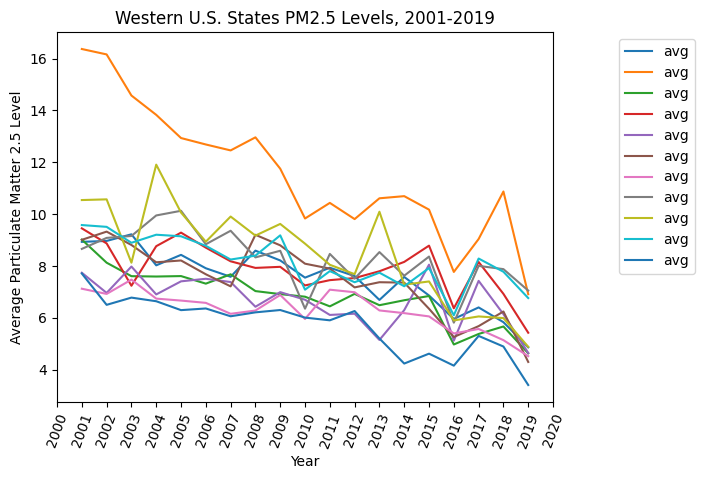

In [ ]:
# Western State initial analysis
west = pm[pm.region == "West"]
fig, ax = plt.subplots()
west.groupby('state').plot(x='year', y='avg', ax=ax)
plt.title("Western U.S. States PM2.5 Levels, 2001-2019")
plt.ylabel("Average Particulate Matter 2.5 Level")
plt.xlabel("Year")
plt.xticks(np.arange(2000, 2021), rotation=70)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
plt.show()

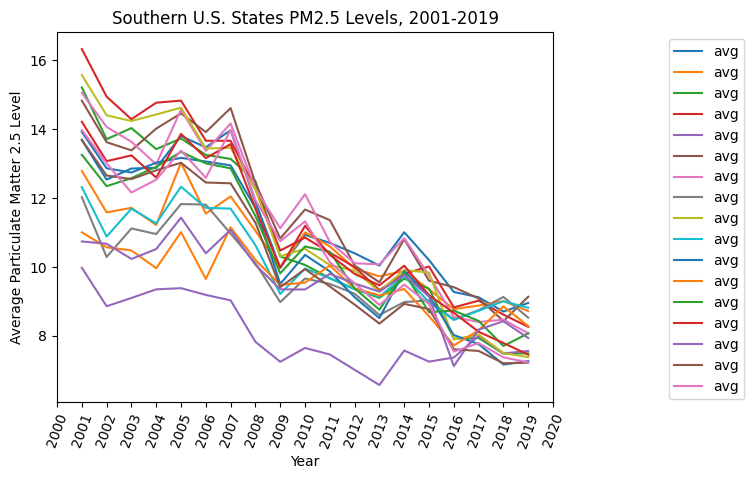

In [ ]:
# Southern states initial analysis 
south = pm[pm.region == "South"]
fig, ax = plt.subplots()
south.groupby('state').plot(x='year', y='avg', ax=ax)
plt.title("Southern U.S. States PM2.5 Levels, 2001-2019")
plt.ylabel("Average Particulate Matter 2.5 Level")
plt.xlabel("Year")
plt.xticks(np.arange(2000, 2021), rotation=70)
plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
plt.show()

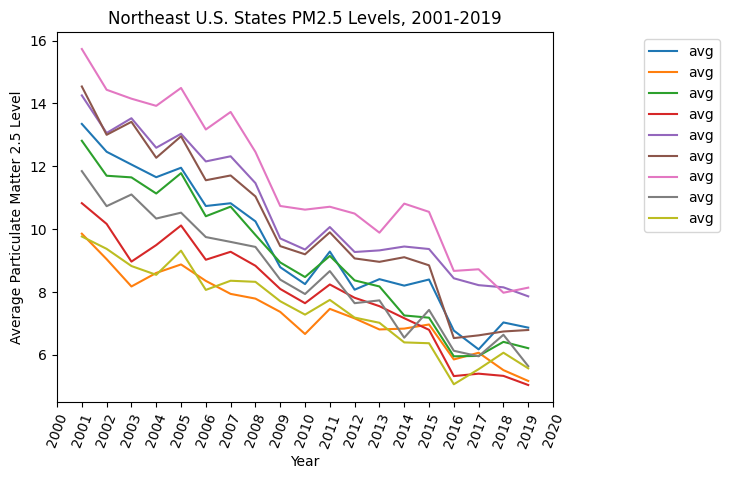

In [ ]:
# Northeastern states initial analysis
ne = pm[pm.region == "Northeast"]
fig, ax = plt.subplots()
ne.groupby('state').plot(x='year', y='avg', ax=ax)
plt.title("Northeast U.S. States PM2.5 Levels, 2001-2019")
plt.ylabel("Average Particulate Matter 2.5 Level")
plt.xlabel("Year")
plt.xticks(np.arange(2000, 2021), rotation=70)
plt.legend(bbox_to_anchor=(1.35, 1), loc="upper right")
plt.show()

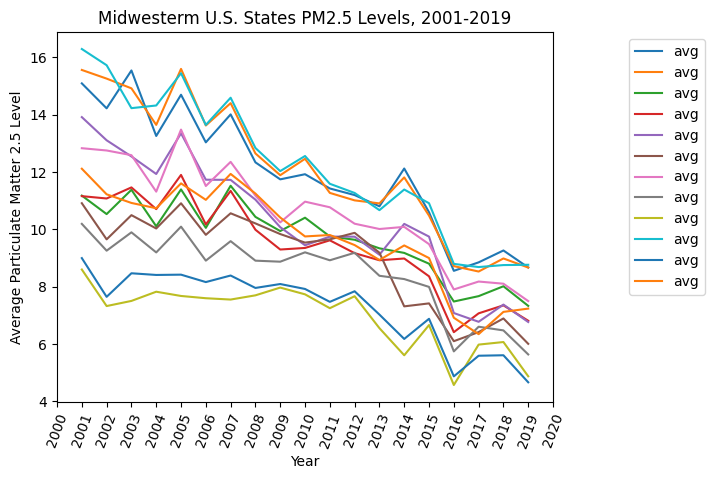

In [ ]:
# Midwestern states initial analysis
mw = pm[pm.region == "Midwest"]
fig, ax = plt.subplots()
mw.groupby('state').plot(x='year', y='avg', ax=ax)
plt.title("Midwesterm U.S. States PM2.5 Levels, 2001-2019")
plt.ylabel("Average Particulate Matter 2.5 Level")
plt.xlabel("Year")
plt.xticks(np.arange(2000, 2021), rotation=70)
plt.legend(bbox_to_anchor=(1.32, 1), loc="upper right")
plt.show()

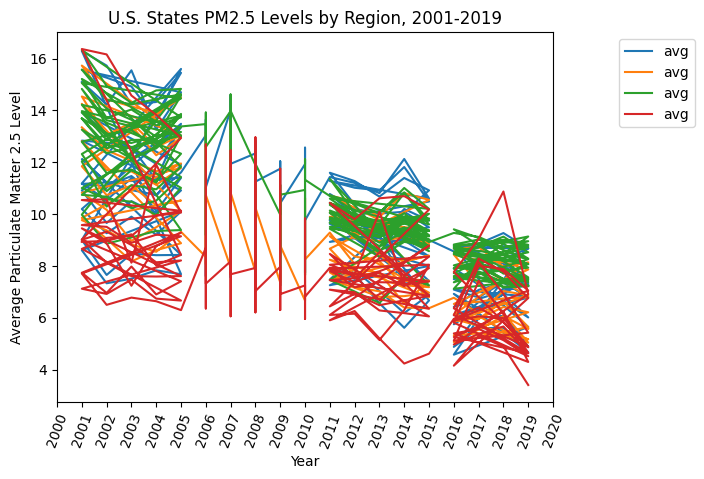

In [ ]:
fig, ax = plt.subplots()
pm.groupby('region').plot(x='year', y='avg', ax=ax)
plt.title("U.S. States PM2.5 Levels by Region, 2001-2019")
plt.ylabel("Average Particulate Matter 2.5 Level")
plt.xlabel("Year")
plt.xticks(np.arange(2000, 2021), rotation=70)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
plt.show()

In [ ]:
# Aggregating data by region to prepare for model creation
region = pm.groupby(["year", "region"]).mean("avg").drop("statefips", axis=1).reset_index()
region_ts = region.pivot(index='year', columns='region', values='avg')
west_ts = region_ts[["West"]]
midwest_ts = region_ts[["Midwest"]]
ne_ts = region_ts[["Northeast"]]
south_ts = region_ts[["South"]]
region_ts

region,Midwest,Northeast,South,West
year,,,,
2001,12.240796,12.551528,13.447849,9.463753
2002,11.485303,11.550723,12.358316,9.178710
2003,11.666528,11.317040,12.356154,8.711815
2004,10.960658,10.948576,12.331719,8.879104
2005,12.051303,11.448225,13.047778,8.740628
2006,10.777332,10.356253,12.335545,8.296990
2007,11.501780,10.494595,12.634120,8.199049
2008,10.543711,9.932621,11.270543,8.227414
2009,10.037808,8.797671,9.807612,8.288729


In [ ]:
wts = west.pivot(index='year', columns='state', values='avg')
sts = south.pivot(index='year', columns='state', values='avg')
nts = ne.pivot(index='year', columns='state', values='avg')
mts = mw.pivot(index='year', columns='state', values='avg')

wts

state,Arizona,California,Colorado,Idaho,Montana,Nevada,New Mexico,Oregon,Utah,Washington,Wyoming
year,,,,,,,,,,,
2001,8.927615,16.369215,9.015802,9.448751,7.735253,9.006427,7.119316,8.656179,10.540883,9.576164,7.705682
2002,8.963350,16.160445,8.123731,8.867896,6.957591,9.322579,6.918241,9.080491,10.567728,9.506644,6.497116
2003,9.219045,14.574203,7.603235,7.234668,7.974700,8.806727,7.471083,9.154652,8.123796,8.891585,6.776271
2004,8.021524,13.828598,7.589732,8.760991,6.899272,8.139491,6.737490,9.946625,11.907113,9.202970,6.636338
2005,8.426094,12.933860,7.606931,9.284065,7.404284,8.209154,6.661634,10.126484,10.058166,9.143104,6.293136
2006,7.908602,12.685309,7.315198,8.704258,7.503173,7.676620,6.573572,8.835395,8.933631,8.773906,6.357226
2007,7.579117,12.456132,7.675468,8.177659,7.377734,7.210424,6.151430,9.356153,9.904311,8.245260,6.055852
2008,8.588864,12.960383,7.027990,7.922501,6.423839,9.200245,6.277488,8.328388,9.169235,8.395218,6.207404
2009,8.210248,11.751283,6.911366,7.963964,6.987482,8.793518,6.877442,8.583891,9.619786,9.179637,6.297405


## Chronic Disease Indicators EDA

In [ ]:
# cancer_cdi = cdi_t[cdi_t["Topic"] == "Cancer"]
# cancer_cdi["Question"].unique()

In [ ]:
# #Filter the Cancer type in the Question column.
# import re
# cancer_types = [
#     'lung and bronchus',
#     'prostate',
#     'cervix',
#     'colon and rectum',
#     'oral cavity and pharynx',
#     'female breast',
#     'female cervix',
#     'invasive melanoma',
#     'melanoma'
# ]
# pattern = r"(" + "|".join(cancer_types) + ")"
# def extract_cancer_type(question):
#     match = re.search(pattern, question, re.IGNORECASE)
#     if match:
#         return match.group(0)
#     return "Unknown"
# cancer_cdi['Cancer_Type'] = cancer_cdi['Question'].apply(extract_cancer_type)
# cancer_cdi[['Topic','Cancer_Type']]

In [ ]:
cdi.head(15)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2012,2012,AK,Alaska,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,2,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
1,2014,2014,AK,Alaska,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,2,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2020,2020,AK,Alaska,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,2,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2012,2012,AL,Alabama,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,1,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
4,2014,2014,AL,Alabama,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,1,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
5,2020,2020,AL,Alabama,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,1,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
6,2012,2012,AR,Arkansas,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,5,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
7,2014,2014,AR,Arkansas,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,5,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
8,2020,2020,AR,Arkansas,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,5,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN
9,2012,2012,AZ,Arizona,Legal Research,Alcohol,Local authority to regulate alcohol outlet den...,NaN,NaN,Local control of the regulation of alcohol out...,...,4,ALC,ALC10_0,LCLCNTRLALC,OVERALL,OVR,NaN,NaN,NaN,NaN


In [ ]:
cdi.sort_values("YearStart")

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
501678,2001,2001,NH,New Hampshire,"NVSS, Mortality",Overarching Conditions,Life expectancy at age 65 years,NaN,Years,Number,...,33,OVC,OVC4_2,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
501706,2001,2001,NY,New York,"NVSS, Mortality",Overarching Conditions,Life expectancy at age 65 years,NaN,Years,Number,...,36,OVC,OVC4_2,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
501699,2001,2001,NV,Nevada,"NVSS, Mortality",Overarching Conditions,Life expectancy at age 65 years,NaN,Years,Number,...,32,OVC,OVC4_2,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
501104,2001,2001,MO,Missouri,"NVSS, Mortality",Overarching Conditions,Life expectancy at birth,NaN,Years,Number,...,29,OVC,OVC4_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
501692,2001,2001,NM,New Mexico,"NVSS, Mortality",Overarching Conditions,Life expectancy at age 65 years,NaN,Years,Number,...,35,OVC,OVC4_2,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722570,2021,2021,IN,Indiana,BRFSS,Diabetes,Prevalence of high cholesterol among adults ag...,NaN,%,Age-adjusted Prevalence,...,18,DIA,DIA11_1,AGEADJPREV,GENDER,GENF,NaN,NaN,NaN,NaN
722571,2021,2021,IN,Indiana,BRFSS,Diabetes,Prevalence of high cholesterol among adults ag...,NaN,%,Crude Prevalence,...,18,DIA,DIA11_1,CRDPREV,RACE,WHT,NaN,NaN,NaN,NaN
722572,2021,2021,IN,Indiana,BRFSS,Diabetes,Prevalence of high cholesterol among adults ag...,NaN,%,Age-adjusted Prevalence,...,18,DIA,DIA11_1,AGEADJPREV,RACE,WHT,NaN,NaN,NaN,NaN
722565,2021,2021,IN,Indiana,BRFSS,Diabetes,Prevalence of high cholesterol among adults ag...,NaN,%,Crude Prevalence,...,18,DIA,DIA11_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN


In [ ]:
# unknown_region_data = cdi[cdi['Region'] == 'Unknown']
# if 'LocationID' in cdi.columns:
#     unknown_region_data = unknown_region_data[['LocationDesc','LocationID', 'DataValue', 'Region']]
# unknown_region_data['LocationDesc'].value_counts()
# # print(unknown_region) 

### Disease 1: Asthma

In [ ]:
def plot_map(data):
    df = data.groupby('LocationAbbr')['DataValue'].agg((sum, 'count', np.mean)).reset_index()
    # df['mean'] = df['sum'] / df['count']
    
    fig = px.choropleth(df, 
                        locations='LocationAbbr', color='sum',
                        color_continuous_scale="blues",
                        locationmode="USA-states",
                        scope="usa"
                    )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

    fig = px.choropleth(df, 
                        locations='LocationAbbr', color='mean',
                        color_continuous_scale="blues",
                        locationmode="USA-states",
                        scope="usa"
                    )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()


def plot_regions(data, metric):
    if metric not in ('sum', 'count', 'mean'):
        return
    df = data.groupby('Region')['DataValue'].agg((sum, 'count', np.mean)).reset_index()
    sns.barplot(df, x='Region', y=metric)

In [ ]:
def filter_dupes(df):
    if len(df.DataValueTypeID.unique()) > 1:
        df = df[df.DataValueType.str.lower().str.contains('adjusted')]
        if len(df) == 0:
            print('oops')
    return df

def adjust_rates(x):
    # print(x)
    if x['DataValueUnit'] == 'cases per 1,000,000':
        x.DataValue /= 10000
    elif x['DataValueUnit'] == 'cases per 10,000':
        x.DataValue /= 100
    elif x['DataValueUnit'] == 'Number':
        x.DataValue /= 10
        
    return x

cdi_clean = cdi[(cdi.StratificationID1 == 'OVR') & (~cdi.DataValueUnit.isna()) & (~cdi.DataValue.isna())]
cdi_clean = cdi_clean.groupby(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question']).apply(filter_dupes)[['DataValueType', 'DataValueUnit', 'DataValue']].reset_index()
cdi_clean['DataValue'] = cdi_clean.DataValue.astype(float)
cdi_clean = cdi_clean.apply(adjust_rates, axis=1)

asthma = cdi_clean[cdi_clean.Topic == 'Asthma']
asthma

,YearStart,YearEnd,LocationAbbr,LocationDesc,Topic,Question,level_6,DataValueType,DataValueUnit,DataValue
2042,2010,2010,AL,Alabama,Asthma,Asthma mortality rate,37257,Age-adjusted Rate,"cases per 1,000,000",0.00119
2069,2010,2010,AR,Arkansas,Asthma,Asthma mortality rate,37521,Age-adjusted Rate,"cases per 1,000,000",0.00114
2070,2010,2010,AR,Arkansas,Asthma,Hospitalizations for asthma,29409,Age-adjusted Rate,"cases per 10,000",0.09500
2103,2010,2010,AZ,Arizona,Asthma,Asthma mortality rate,37785,Age-adjusted Rate,"cases per 1,000,000",0.00086
2104,2010,2010,AZ,Arizona,Asthma,Emergency department visit rate for asthma,21951,Age-adjusted Rate,"cases per 10,000",0.63950
...,...,...,...,...,...,...,...,...,...,...
75494,2021,2021,WY,Wyoming,Asthma,Current asthma prevalence among adults aged >=...,1172115,Age-adjusted Prevalence,%,9.60000
75495,2021,2021,WY,Wyoming,Asthma,Influenza vaccination among noninstitutionaliz...,1172137,Age-adjusted Prevalence,%,29.80000
75496,2021,2021,WY,Wyoming,Asthma,Influenza vaccination among noninstitutionaliz...,1172153,Age-adjusted Prevalence,%,62.50000
75497,2021,2021,WY,Wyoming,Asthma,Pneumococcal vaccination among noninstitutiona...,1172169,Age-adjusted Prevalence,%,32.80000


In [ ]:
plot_map(asthma)

We had to do preprocessing for the CDI datasets to make all the data value units the same (% based). We then observed the differences in aggregated datavalues across states (one plot shows the sum in each state, the other shows the mean). This is relevant to our first research question about the differences in chronic diseases over regions because it shows the data values for asthma at a lower granularity. We will probably use mean because it accounts for different numbers of data points across states.

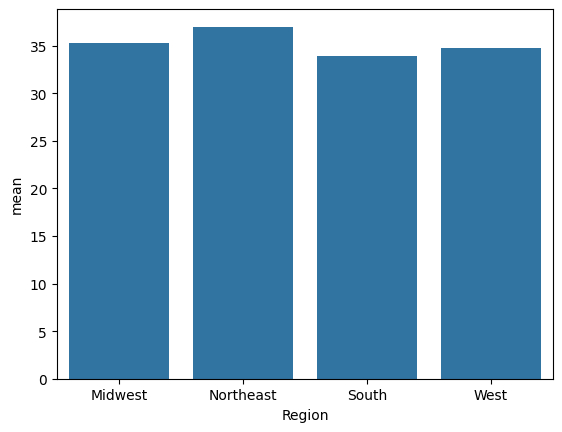

In [ ]:
asthma['Region'] = asthma.LocationDesc.apply(state_name_to_region)
asth = asthma[asthma.Region != 'Unknown']
plot_regions(asth, 'mean')

This plots the mean by region, and the data values are highest in the Northeast, although the differences in means aren't huge.

<AxesSubplot: ylabel='Question'>

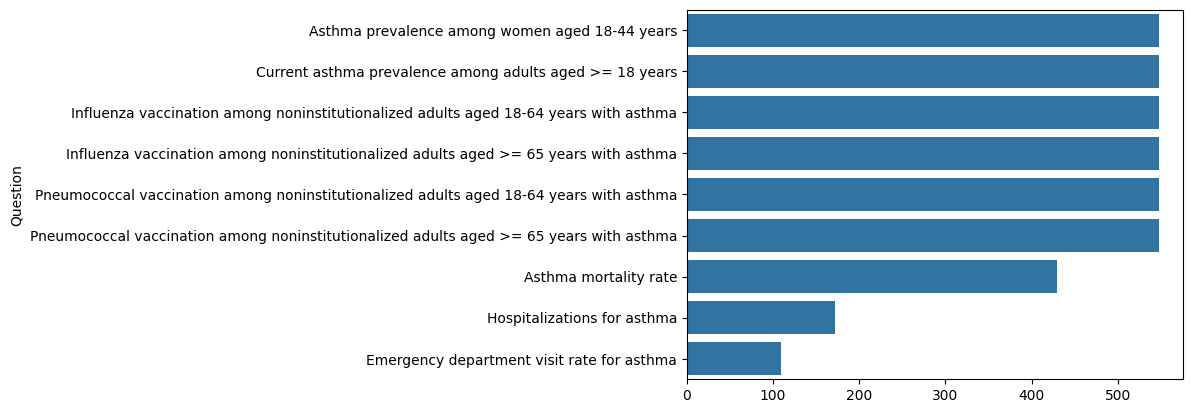

In [ ]:
df = asth.Question.value_counts()
sns.barplot(y = df.index, x = df.values)

This is an exploratory graph showing the distribution of questions related to asthma to give us a better idea of what the data values related to asthma actually mean. It appears that most of them represent the prevalence and severity of the disease, so this would be good to move forward with.

"

In [ ]:
print(cdi_clean.Topic.unique())
lifestyle = cdi_clean[cdi_clean.Topic.isin(['Overarching Conditions', 'Tobacco',
    'Mental Health', 'Oral Health', 'Alcohol',
    'Nutrition, Physical Activity, and Weight Status',
    'Immunization'])]
lifestyle = lifestyle.groupby(['YearEnd', 'Region', 'LocationAbbr', 'LocationDesc', 'Topic'])['DataValue'].mean().reset_index()

['Overarching Conditions' 'Tobacco' 'Cancer' 'Diabetes' 'Mental Health'
 'Oral Health' 'Alcohol' 'Cardiovascular Disease' 'Chronic Kidney Disease'
 'Chronic Obstructive Pulmonary Disease' 'Disability'
 'Nutrition, Physical Activity, and Weight Status' 'Older Adults' 'Asthma'
 'Arthritis' 'Immunization' 'Reproductive Health']


KeyError: 'Region'

# Research Question 1: GLM and Nonparametric Modeling for PM2.5 Level Prediction

## Parametric Modeling

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

def model_creation(df):
    '''
    Conducts TimeSeries Cross Validation for prediction and output the evaluation results
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    arima_rmse = []
    sarima_rmse = []
    lr_rmse = []
    l1_rmse = []
    l2_rmse = []

    # hyperparameter tuning
    auto_test = auto_arima(df, trace=True, with_intercept=True, suppress_warnings=True)
    order = auto_test.get_params()['order']
    seasonal_order = auto_test.get_params()['seasonal_order']
    trend = auto_test.get_params()['trend']

    for train_index, test_index in tscv.split(df):
        cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
        arima = sm.tsa.arima.ARIMA(cv_train, 
                                    order=order, 
                                    trend = trend,
                                    seasonal_order = seasonal_order).fit()
        y_hat_arima = arima.predict(cv_test.index.values[0], cv_test.index.values[-1])
        true_values = cv_test.values
        rmse = np.sqrt(mean_squared_error(true_values, y_hat_arima))
        arima_rmse.append(rmse)

        sarima = sm.tsa.statespace.SARIMAX(cv_train, 
                                    order=order, 
                                    trend = trend,
                                    seasonal_order = seasonal_order).fit(disp=False)
        y_hat_sarima = sarima.predict(cv_test.index.values[0], cv_test.index.values[-1])
        true_values = cv_test.values
        rmse = np.sqrt(mean_squared_error(true_values, y_hat_sarima))
        sarima_rmse.append(rmse)

    print("ARIMA Model RMSE: {}".format(np.mean(arima_rmse)))
    print("SARIMA Model RMSE: {}".format(np.mean(sarima_rmse)))

In [ ]:
auto_test= auto_arima(region_ts['West'], trace=True, with_intercept=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.150, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.984, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.552, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27.066, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26.577, Time=0.59 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=28.162, Time=0.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=26.929, Time=2.96 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.273, Time=0.43 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 8.709 seconds


In [ ]:
auto_test.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
region_ts.index = pd.to_datetime(region_ts.index, format='%Y')

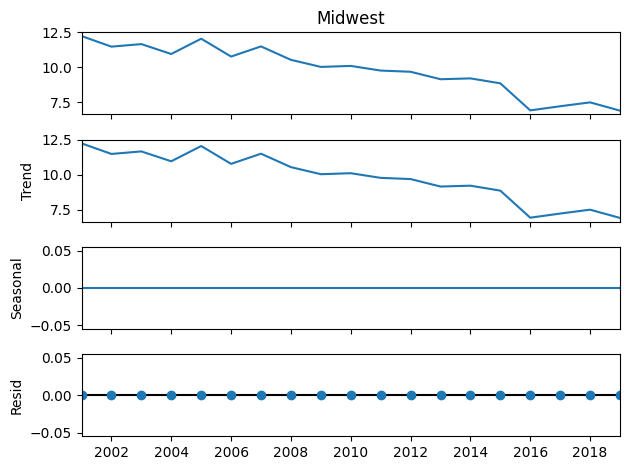

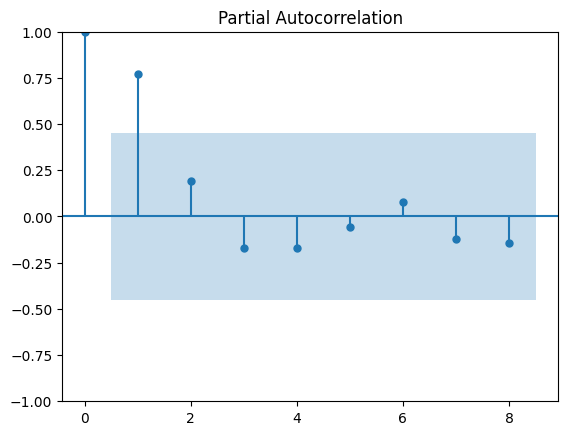

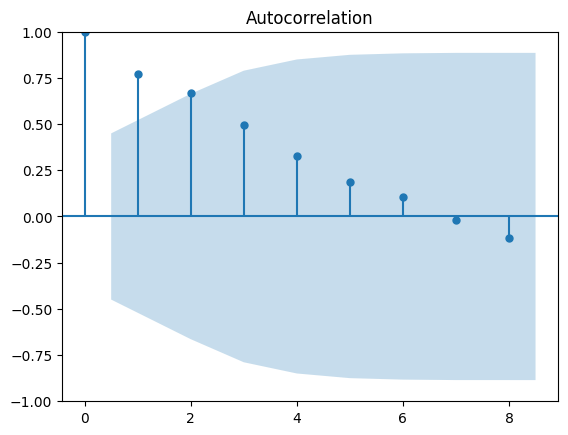

ADF Statistic: 3.2769360842249147
p-value: 1.0
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603


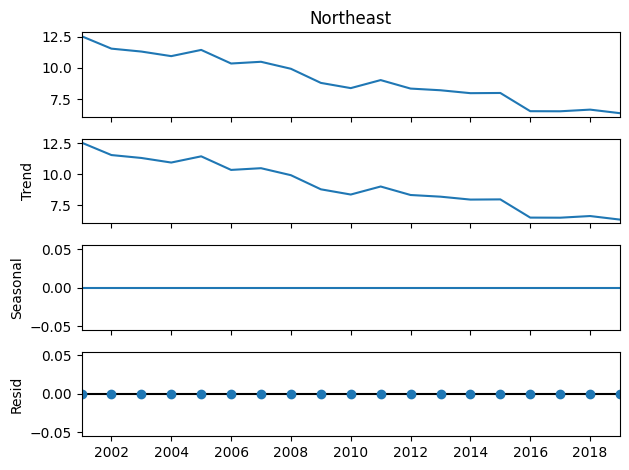

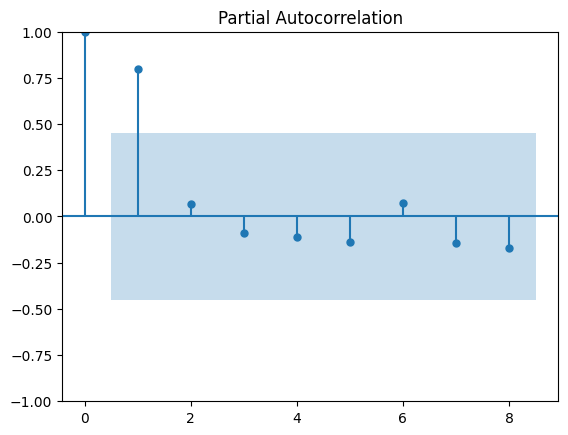

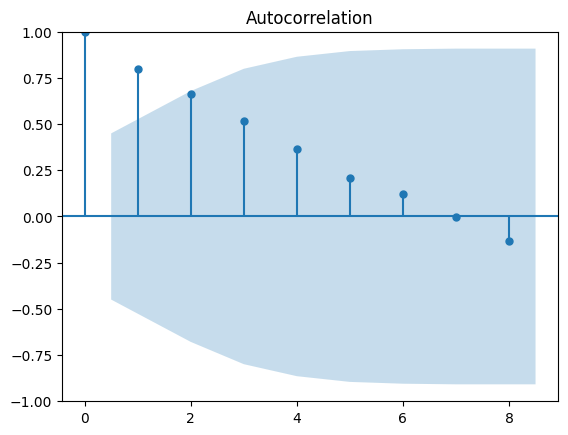

ADF Statistic: -3.5016541921972695
p-value: 0.007944712393553802
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603


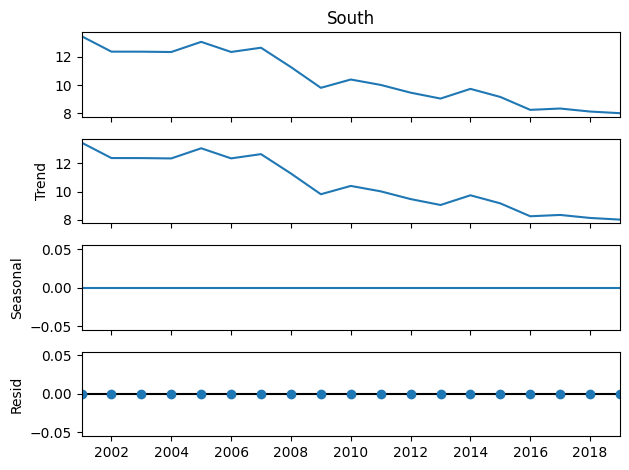

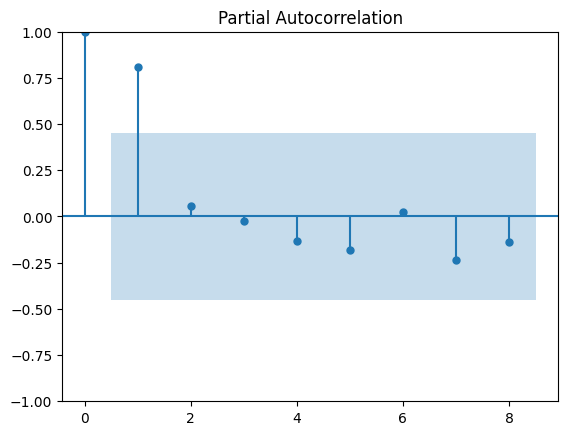

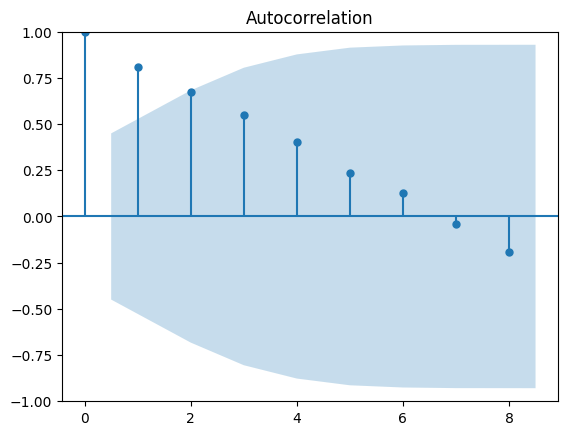

ADF Statistic: -3.554459119726358
p-value: 0.006693790464209571
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443


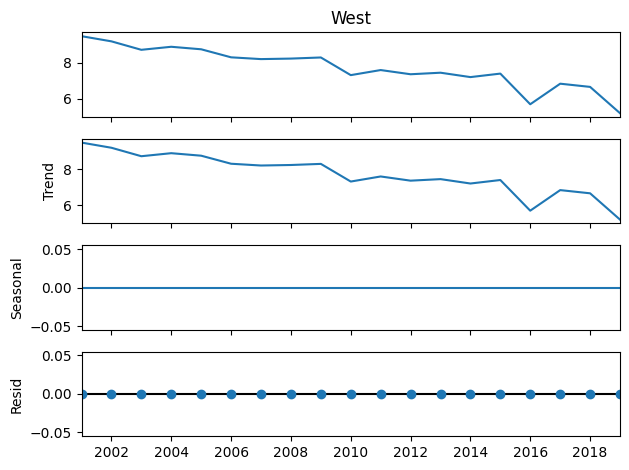

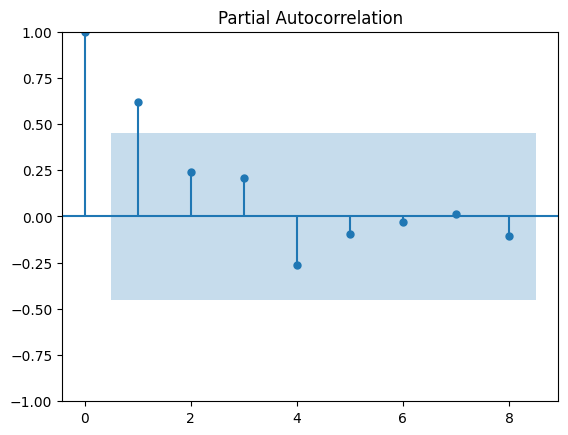

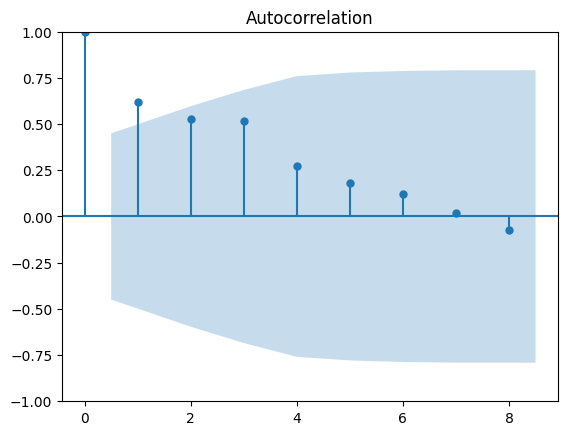

ADF Statistic: 0.7651636438599273
p-value: 0.9910525167115193
Critical Values:
	1%: -4.068853732362312
	5%: -3.1271488757396453
	10%: -2.7017297633136095


In [ ]:
from statsmodels.tsa.stattools import adfuller

cols = region_ts.columns

for col in cols: 
    ts = region_ts[col]
    decomposition = sm.tsa.seasonal_decompose(ts)
    fig = decomposition.plot()
    plot_pacf(ts, lags=8)
    plot_acf(ts, lags=8)
    plt.show()

    result = adfuller(ts)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    

In [ ]:
cols = region_ts.columns

for col in cols: 
    ts = region_ts[col]
    print(f"Models for {col}")
    model_creation(ts)
    print("+++++++++++++++++++++++++++++++++++++\n")

Models for Midwest
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.236, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.873, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.310, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.196, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.287, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38.300, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40.159, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=43.693, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.017 seconds
ARIMA Model RMSE: 0.8853297667895987
SARIMA Model RMSE: 0.8853297667895987
+++++++++++++++++++++++++++++++++++++

Models for Northeast
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.747,

In [ ]:
tmp = west_ts.copy()

In [ ]:
tmp['lag1'] = tmp['West'].shift(-1)
tmp['lag2'] = tmp['West'].shift(-2)
tmp

region,West,lag1,lag2
year,,,
2001,9.463753,9.178710,8.711815
2002,9.178710,8.711815,8.879104
2003,8.711815,8.879104,8.740628
2004,8.879104,8.740628,8.296990
2005,8.740628,8.296990,8.199049
2006,8.296990,8.199049,8.227414
2007,8.199049,8.227414,8.288729
2008,8.227414,8.288729,7.314422
2009,8.288729,7.314422,7.594428


In [ ]:
    X = tmp.drop("West", axis=1)
    y = tmp["West"]
    X

region,lag1,lag2
year,,
2001,9.178710,8.711815
2002,8.711815,8.879104
2003,8.879104,8.740628
2004,8.740628,8.296990
2005,8.296990,8.199049
2006,8.199049,8.227414
2007,8.227414,8.288729
2008,8.288729,7.314422
2009,7.314422,7.594428


In [ ]:
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(X)

<generator object TimeSeriesSplit.split at 0x7f57817d10b0>

In [ ]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def regression_modeling(df, region):
    df['lag1'] = df[region].shift(-1)
    df['lag2'] = df[region].shift(-2)
    df = df[:-2]

    X = df.drop(region, axis=1)
    y = df[region]

    tscv = TimeSeriesSplit(n_splits=3)
    tscv.split(X)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X_test) 
    lrrmse = np.sqrt(mean_squared_error(y_test, y_hat))
    # results['MLR Predicted'] = y_hat

    l2 = Ridge(alpha=0.5)
    l2.fit(X_train, y_train)
    y_hat = l2.predict(X_test)
    l2rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    # results['Ridge Predicted'] = y_hat

    ls = Lasso(alpha=0.01)
    ls.fit(X_train, y_train)
    y_hat = ls.predict(X_test)
    l1rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    # results['Lasso Predicted'] = y_hat

    plt.plot(X.index,y, label="True Value", marker='o')

    plt.plot(X_train.index, lr.predict(X_train), label='MLR Fitted', marker='o')
    plt.plot(X_test.index, lr.predict(X_test), label="MLR Predictions", linestyle='--')

    plt.plot(X_train.index, l2.predict(X_train), label='Ridge Fitted', marker='o')
    plt.plot(X_test.index, l2.predict(X_test), label="Ridge Predictions", linestyle='--')

    plt.plot(X_train.index, ls.predict(X_train), label='Lasso Fitted', marker='o')
    plt.plot(X_test.index, ls.predict(X_test), label="Lasso Prediction", linestyle='--')

    plt.legend()
    plt.title(f"{region} Region Regression Predictions vs. True Observations")
    plt.xlabel("Year")
    plt.ylabel("Scaled Value")
    plt.show()

    print(f'GLMs Evaluations for {region} Models')
    print("MLR RMSE: ", lrrmse)
    print("Ridge RMSE: ", l2rmse)
    print("Lasso RMSE: ", l1rmse)

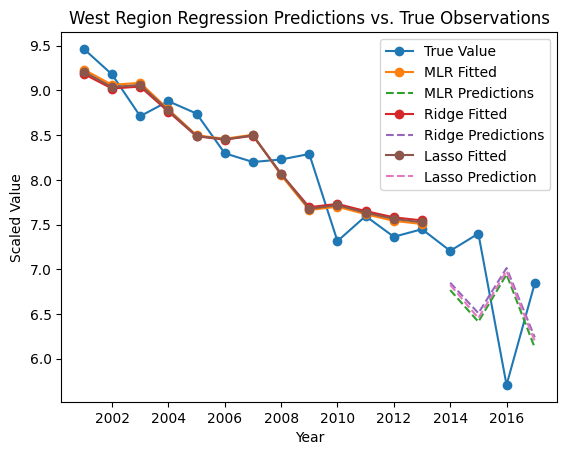

GLMs Evaluations for West Models
MLR RMSE:  0.89544453736384
Ridge RMSE:  0.864209636247009
Lasso RMSE:  0.876880569416016


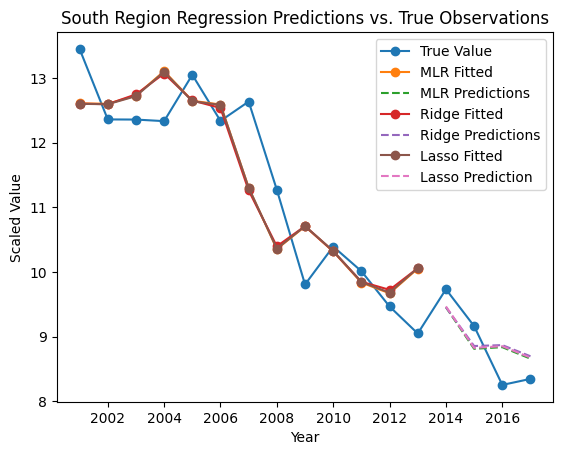

GLMs Evaluations for South Models
MLR RMSE:  0.39934261272982663
Ridge RMSE:  0.4100282691535787
Lasso RMSE:  0.40286900410186427


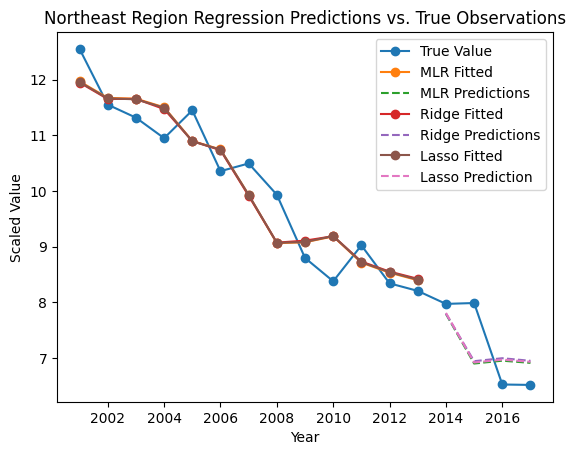

GLMs Evaluations for Northeast Models
MLR RMSE:  0.6230907005508838
Ridge RMSE:  0.6188304541830464
Lasso RMSE:  0.6200967130322945


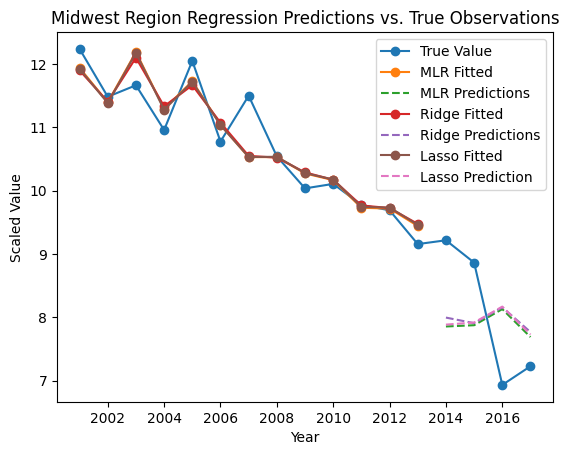

GLMs Evaluations for Midwest Models
MLR RMSE:  1.058126201019938
Ridge RMSE:  1.0247916369179844
Lasso RMSE:  1.0548903793683426


In [ ]:
data = {"West": west_ts, 
        "South" : south_ts, 
        "Northeast" : ne_ts, 
        "Midwest" : midwest_ts}

for k, v in data.items():
    regression_modeling(v, k)

## Nonparametric Modeling

In [ ]:
import torch
import matplotlib.pyplot as plt
from tensorflow import keras


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
region_ts

region,Midwest,Northeast,South,West
year,,,,
2001-01-01,12.240796,12.551528,13.447849,9.463753
2002-01-01,11.485303,11.550723,12.358316,9.178710
2003-01-01,11.666528,11.317040,12.356154,8.711815
2004-01-01,10.960658,10.948576,12.331719,8.879104
2005-01-01,12.051303,11.448225,13.047778,8.740628
2006-01-01,10.777332,10.356253,12.335545,8.296990
2007-01-01,11.501780,10.494595,12.634120,8.199049
2008-01-01,10.543711,9.932621,11.270543,8.227414
2009-01-01,10.037808,8.797671,9.807612,8.288729


In [ ]:
from keras.layers import LSTM, Dropout, Dense

def lag_data(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def nonparam_model (df, region):
    average_values = df[region].values.reshape(-1, 1)

    scaler = StandardScaler()
    average_values_scaled = scaler.fit_transform(average_values)

    sequence_length = 2 
    sequences, targets = lag_data(average_values_scaled, sequence_length)

    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, shuffle=False)

    model = keras.Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=False)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and true values to get the actual values
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test)

    # Inverse transform the fitted values for the training set
    y_fitted_train = scaler.inverse_transform(model.predict(X_train))

    # Calculate RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    print(f'{region} LSTM RMSE: {rmse}')

    future_predictions = []
    last_sequence = average_values_scaled[-sequence_length:]

    for _ in range(3):
        next_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
        future_predictions.append(next_prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

    future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(region_ts.index[:11], y_fitted_train, label='Fitted Values (Training Set)', marker='o')
    plt.plot(region_ts.index, average_values, label='True Values (Test Set)', marker='o')
    plt.plot(region_ts.index[11:17], y_pred_actual, label='Predicted Values (Test Set)', marker='o', linestyle='--')
    plt.plot(region_ts.index[16:19], future_predictions_actual, label='Future Forecast Values (Test Set)',linestyle='--')
    plt.title(f'{region} LSTM Model with Lag of 2 Years')
    plt.xlabel('Year')
    plt.ylabel('Average Value')
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 43ms/step
West LSTM RMSE: 1.0120408295527568
1/1 [==============================] - 0s 49ms/step


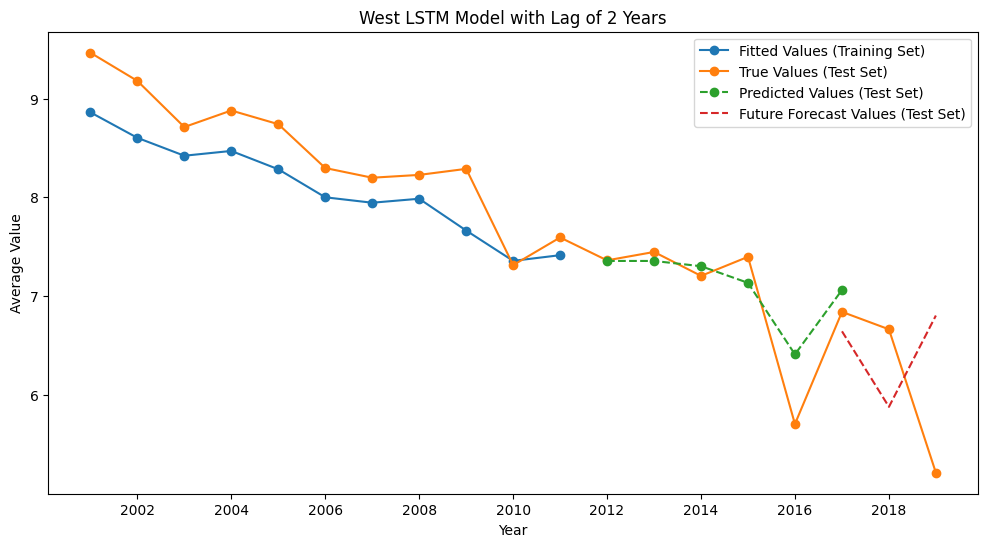

1/1 [==============================] - 0s 34ms/step
South LSTM RMSE: 0.5570122200006885
1/1 [==============================] - 0s 30ms/step


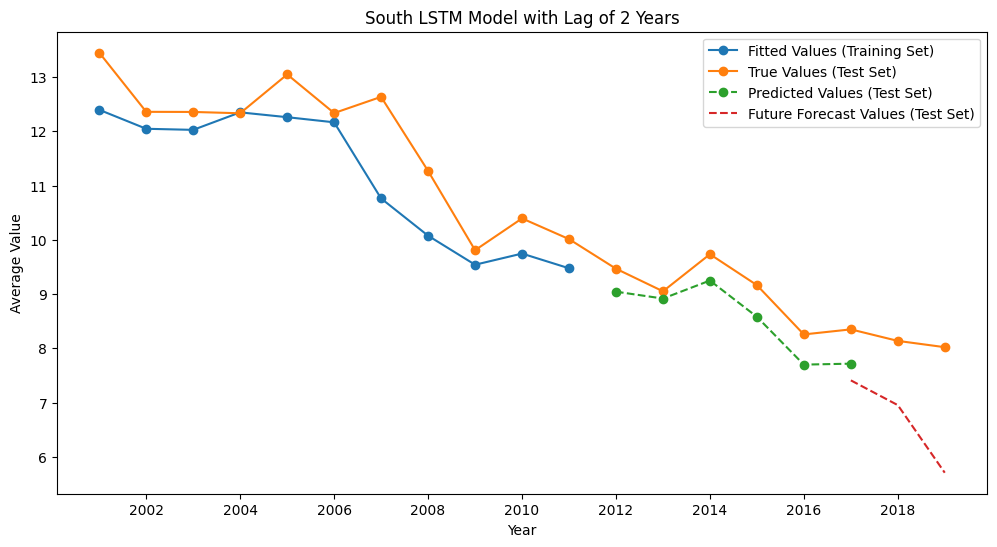

1/1 [==============================] - 0s 31ms/step
Northeast LSTM RMSE: 1.0683576006008528
1/1 [==============================] - 0s 38ms/step


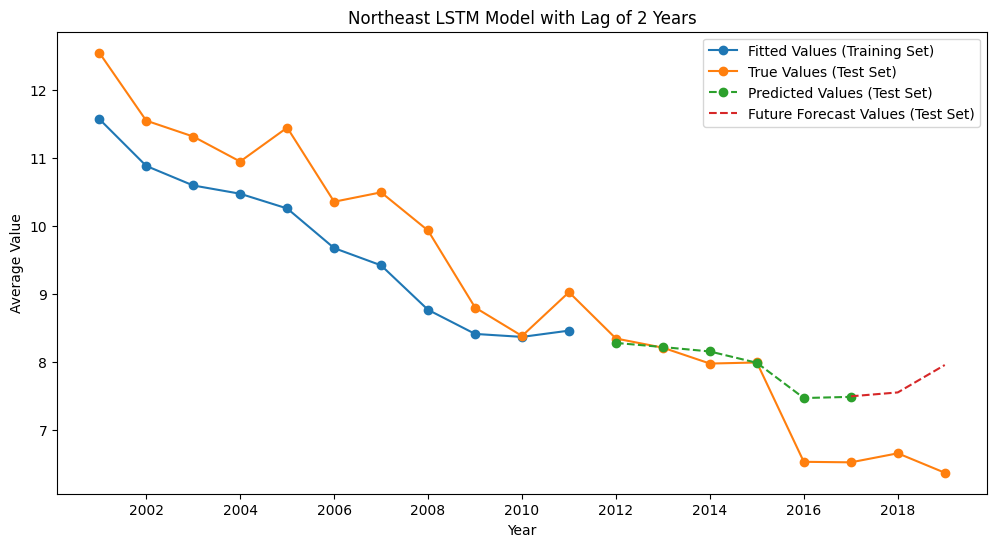

1/1 [==============================] - 0s 32ms/step
Midwest LSTM RMSE: 1.838727066812152
1/1 [==============================] - 0s 31ms/step


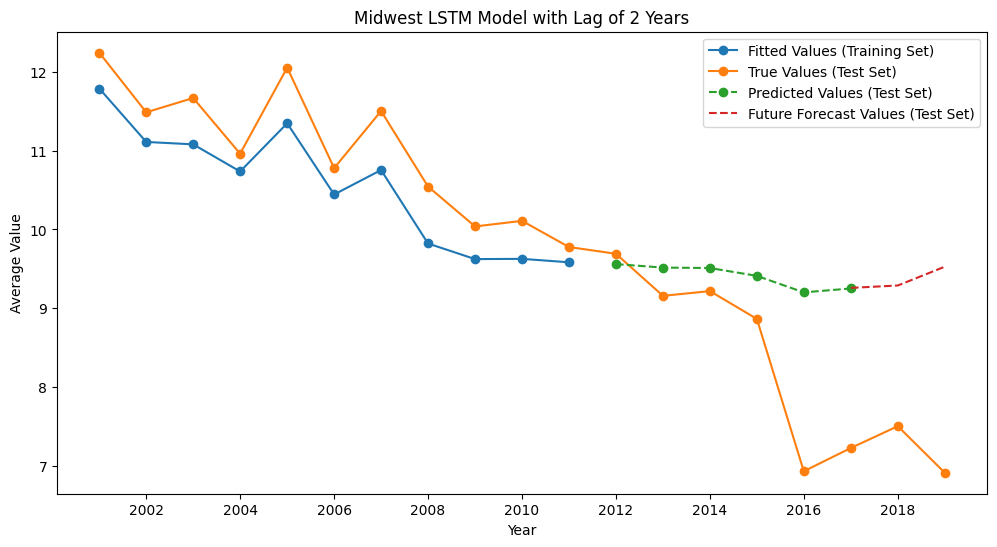

In [ ]:
data = {"West": west_ts, 
        "South" : south_ts, 
        "Northeast" : ne_ts, 
        "Midwest" : midwest_ts}

for k, v in data.items():
    nonparam_model(v, k)

In [ ]:
from sklearn.utils import resample

def uncertainty(df, region): 
    df['lag1'] = df[region].shift(-1)
    df['lag2'] = df[region].shift(-2)
    df = df[:-2]

    X = df.drop(region, axis=1)
    y = df[region]

    tscv = TimeSeriesSplit(n_splits=3)
    tscv.split(X)

    mlr_unc = pd.DataFrame(columns=["Pred", "Lower", "Upper"])
    l2_unc = pd.DataFrame(columns=["Pred", "Lower", "Upper"])
    ls_unc = pd.DataFrame(columns=["Pred", "Lower", "Upper"])

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X) 
    resid = y - y_hat
    T = len(y)
    K = 2
    M = 2
    s = np.sqrt((1/(T-K-M)) * np.sum(resid))
    mlr_unc['Pred'] = y
    mlr_unc['Upper'] = y + s*1.95
    mlr_unc['Lower'] = y - s*1.95


    l2 = Ridge(alpha=0.5)
    l2.fit(X_train, y_train)
    y_hat = l2.predict(X)
    resid = y - y_hat
    T = len(y)
    K = 2
    M = 2
    s = np.sqrt((1/(T-K-M)) * np.sum(resid))
    l2_unc['Pred'] = y
    l2_unc['Upper'] = y_hat + s*1.95
    l2_unc['Lower'] = y_hat - s*1.95

    ls = Lasso(alpha=0.01)
    ls.fit(X_train, y_train)
    y_hat = ls.predict(X)
    resid = y - y_hat
    T = len(y)
    K = 2
    M = 2
    s = np.sqrt((1/(T-K-M)) * np.sum(resid))
    ls_unc['Pred'] = y_hat
    ls_unc['Upper'] = y_hat + s*1.95
    ls_unc['Lower'] = y_hat - s*1.95

    plt.figure(figsize=(12, 5))

    plt.subplot(1,3,1)
    plt.plot(X.index, mlr_unc['Pred'], label='MLR Fitted', marker='o')
    plt.plot(X.index, y, label='True', marker='o')
    plt.plot(X.index, mlr_unc['Upper'], linestyle='--')
    plt.plot(X.index, mlr_unc['Lower'], linestyle='--')
    plt.legend()
    plt.title(f"{region} MLR Uncertain Plot")
    plt.xlabel("Year")
    plt.ylabel("Value")

    plt.subplot(1,3,2)
    plt.plot(X.index, l2_unc['Pred'], label='Ridge Fitted', marker='o')
    plt.plot(X.index, y, label='True', marker='o')
    plt.plot(X.index, l2_unc['Upper'], linestyle='--')
    plt.plot(X.index, l2_unc['Lower'], linestyle='--')
    plt.legend()
    plt.title(f"{region} Ridge Uncertain Plot")
    plt.xlabel("Year")
    plt.ylabel("Value")

    plt.subplot(1,3,3)
    plt.plot(X.index, ls_unc['Pred'], label='Lasso Fitted', marker='o')
    plt.plot(X.index, y, label='True', marker='o')
    plt.plot(X.index, ls_unc['Upper'], linestyle='--')
    plt.plot(X.index, ls_unc['Lower'], linestyle='--')
    plt.legend()
    plt.title(f"{region} Lasso Uncertain Plot")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.show()

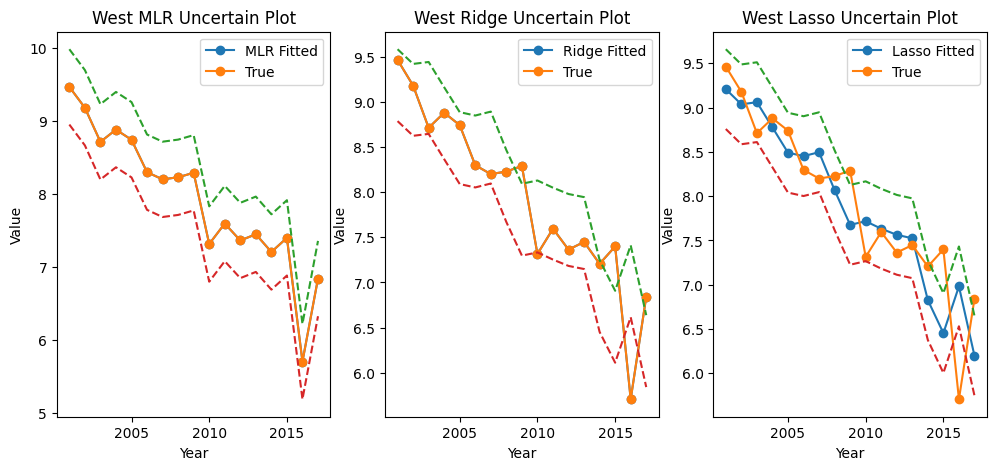

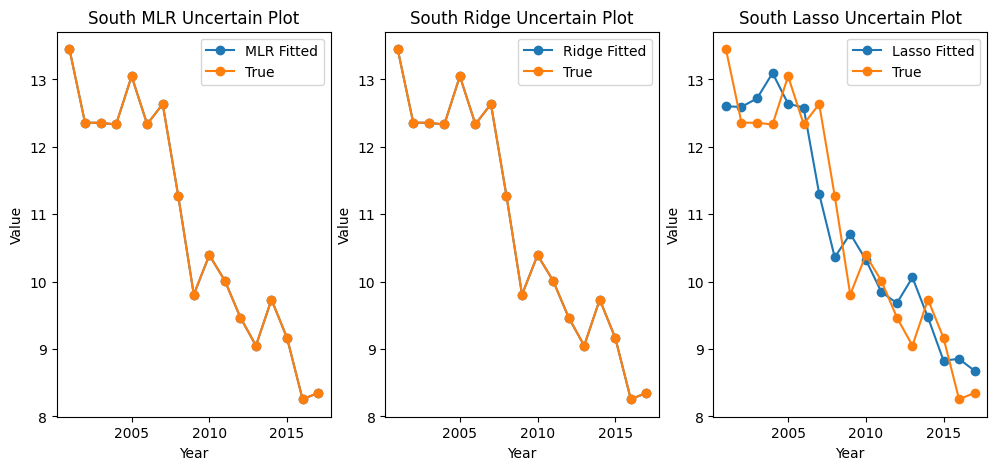

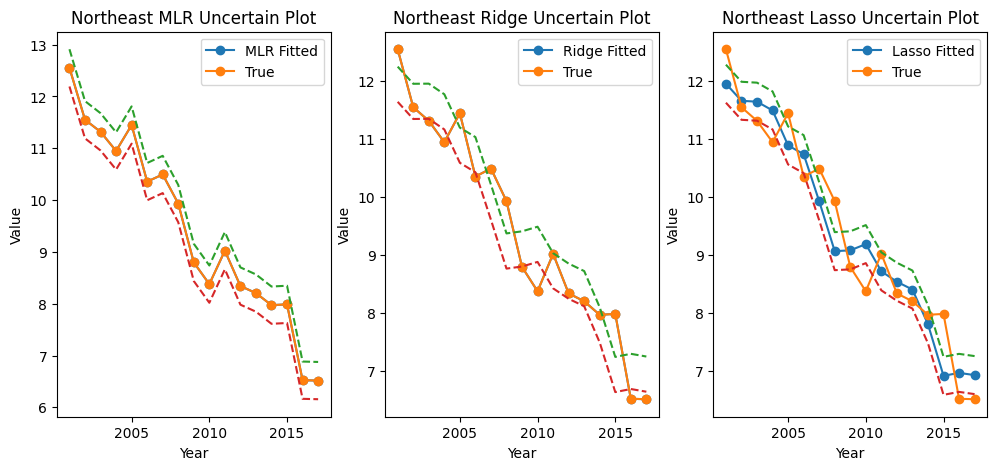

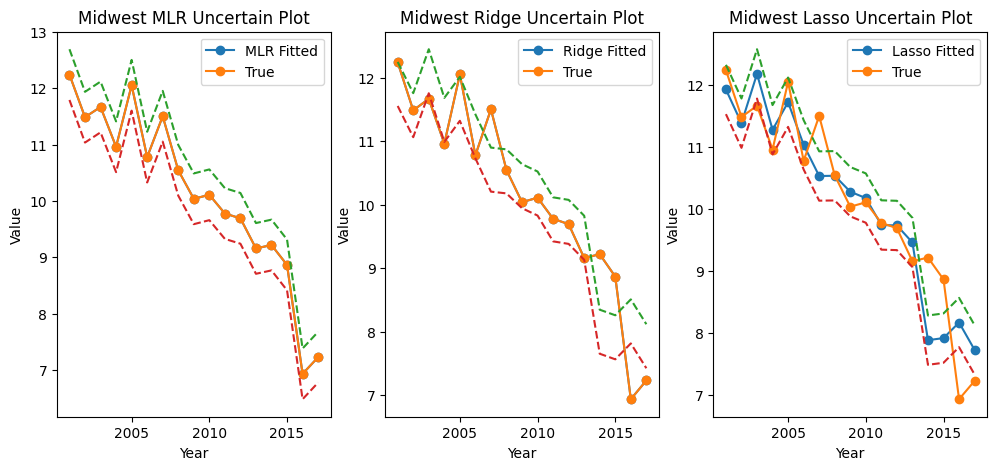

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 

data = {"West": west_ts, 
        "South" : south_ts, 
        "Northeast" : ne_ts, 
        "Midwest" : midwest_ts}

for k, v in data.items():
    uncertainty(v, k)

# Research Question 2: Bayesian Hierarchical Modeling for Chronic Disease Indicators

## PyMC for Asthma

In [ ]:
#Add Regions and modify data to look better
asth = asthma.drop('YearStart', axis = 1)
asth = asth.rename(columns = {"YearEnd": "Year"})
asth

,Year,LocationAbbr,LocationDesc,Topic,Question,level_6,DataValueType,DataValueUnit,DataValue,Region
2042,2010,AL,Alabama,Asthma,Asthma mortality rate,37257,Age-adjusted Rate,"cases per 1,000,000",0.00119,South
2069,2010,AR,Arkansas,Asthma,Asthma mortality rate,37521,Age-adjusted Rate,"cases per 1,000,000",0.00114,South
2070,2010,AR,Arkansas,Asthma,Hospitalizations for asthma,29409,Age-adjusted Rate,"cases per 10,000",0.09500,South
2103,2010,AZ,Arizona,Asthma,Asthma mortality rate,37785,Age-adjusted Rate,"cases per 1,000,000",0.00086,West
2104,2010,AZ,Arizona,Asthma,Emergency department visit rate for asthma,21951,Age-adjusted Rate,"cases per 10,000",0.63950,West
...,...,...,...,...,...,...,...,...,...,...
75494,2021,WY,Wyoming,Asthma,Current asthma prevalence among adults aged >=...,1172115,Age-adjusted Prevalence,%,9.60000,West
75495,2021,WY,Wyoming,Asthma,Influenza vaccination among noninstitutionaliz...,1172137,Age-adjusted Prevalence,%,29.80000,West
75496,2021,WY,Wyoming,Asthma,Influenza vaccination among noninstitutionaliz...,1172153,Age-adjusted Prevalence,%,62.50000,West
75497,2021,WY,Wyoming,Asthma,Pneumococcal vaccination among noninstitutiona...,1172169,Age-adjusted Prevalence,%,32.80000,West


In [ ]:
#Fix Population data to fit the asthma data
pop1 = pop10_20.iloc[:, [3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]].drop(index = 56)
pop2 = pop2021.iloc[:, [7]].drop(index = 56)
pop = pd.concat([pop1, pop2], axis=1)
pop = pop.rename(columns={'POPESTIMATE2010': 2010, 'POPESTIMATE2011': 2011, 'POPESTIMATE2012': 2012, 'POPESTIMATE2013': 2013, 'POPESTIMATE2014': 2014, 'POPESTIMATE2015': 2015, 'POPESTIMATE2016': 2016, 'POPESTIMATE2017': 2017, 'POPESTIMATE2018': 2018, 'POPESTIMATE2019': 2019, 'POPESTIMATE2020': 2020, 'POPESTIMATE2021': 2021})
pop

,STATE,NAME,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,United States,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123,331893745
1,0,Northeast Region,55380764,55608318,55782661,55912775,56021339,56052790,56063777,56083383,56084543,56002934,55849869,57159838
2,0,Midwest Region,66975328,67164092,67348275,67576524,67765576,67885682,68018175,68160342,68263019,68340091,68316744,68841444
3,0,South Region,114869421,116019483,117264196,118397213,119666248,121049223,122419547,123611036,124649156,125686544,126662754,127225329
4,0,West Region,72101630,72791588,73482530,74173435,74933166,75751299,76570256,77267367,77841481,78300384,78654756,78667134
5,1,Alabama,4785514,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532,5039877
6,2,Alaska,713982,722349,730810,737626,737075,738430,742575,740983,736624,733603,731158,732673
7,4,Arizona,6407342,6473416,6556344,6634690,6732873,6832810,6944767,7048088,7164228,7291843,7421401,7276316
8,5,Arkansas,2921998,2941038,2952876,2960459,2968759,2979732,2991815,3003855,3012161,3020985,3030522,3025891
9,6,California,37319550,37636311,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39368078,39237836


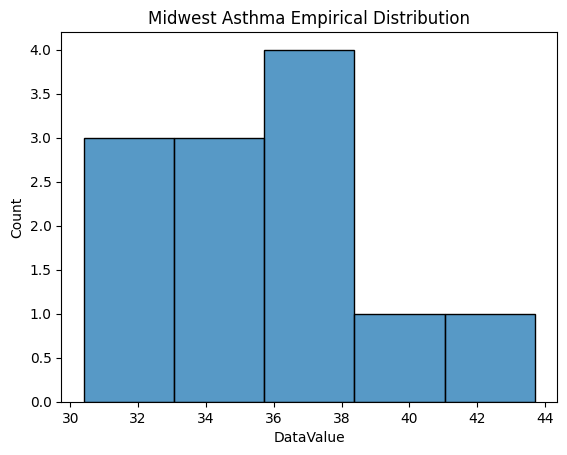

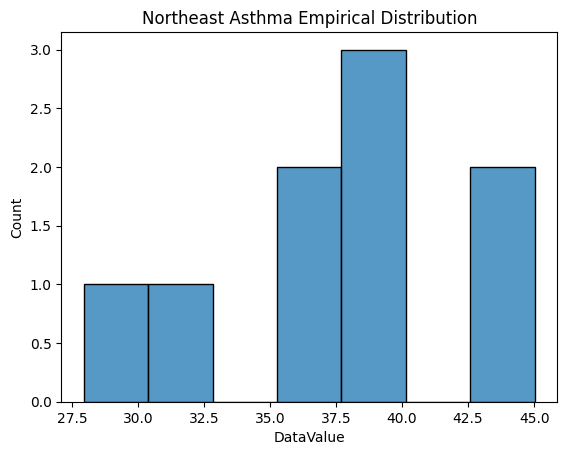

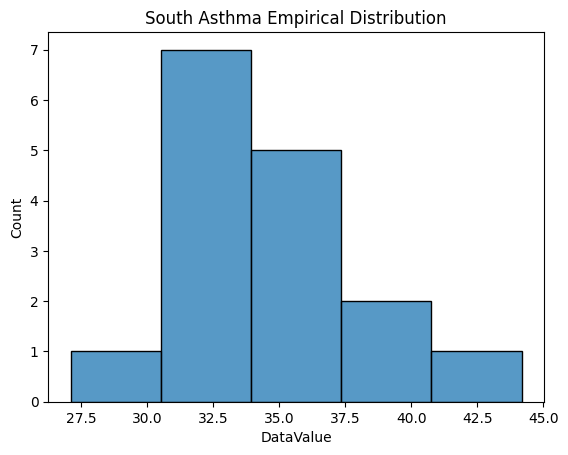

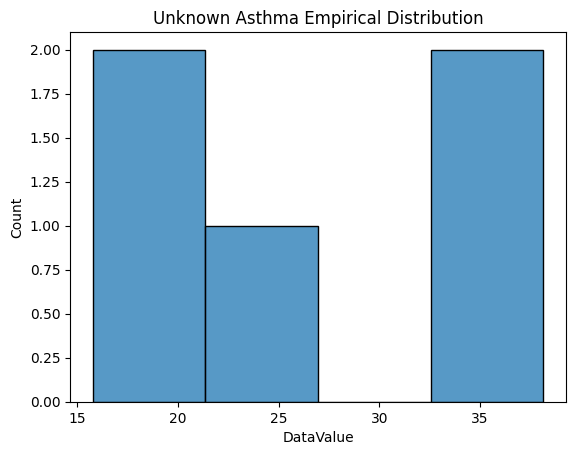

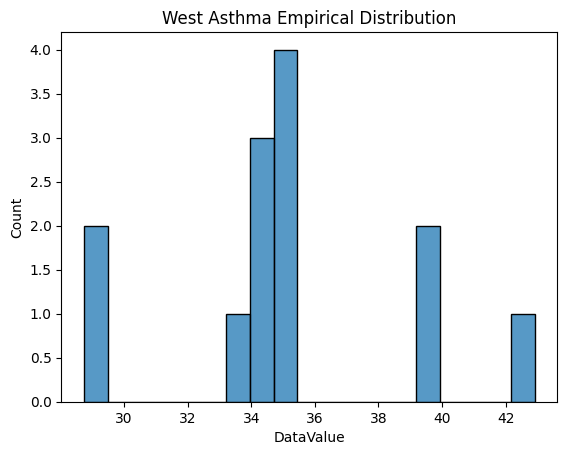

In [ ]:
for region in tmp.Region.unique():
    sns.histplot(tmp[tmp.Region == region], x = 'DataValue')
    plt.title(f'{region} Asthma Empirical Distribution')
    plt.show()

In [ ]:
asth_fil = asth.loc[:,['Year', 'LocationDesc', 'Question', 'DataValue', 'Region']]
asth_fil

,Year,LocationDesc,Question,DataValue,Region
2042,2010,Alabama,Asthma mortality rate,0.00119,South
2069,2010,Arkansas,Asthma mortality rate,0.00114,South
2070,2010,Arkansas,Hospitalizations for asthma,0.09500,South
2103,2010,Arizona,Asthma mortality rate,0.00086,West
2104,2010,Arizona,Emergency department visit rate for asthma,0.63950,West
...,...,...,...,...,...
75494,2021,Wyoming,Current asthma prevalence among adults aged >=...,9.60000,West
75495,2021,Wyoming,Influenza vaccination among noninstitutionaliz...,29.80000,West
75496,2021,Wyoming,Influenza vaccination among noninstitutionaliz...,62.50000,West
75497,2021,Wyoming,Pneumococcal vaccination among noninstitutiona...,32.80000,West


In [ ]:
pop

,STATE,NAME,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,United States,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123,331893745
1,0,Northeast Region,55380764,55608318,55782661,55912775,56021339,56052790,56063777,56083383,56084543,56002934,55849869,57159838
2,0,Midwest Region,66975328,67164092,67348275,67576524,67765576,67885682,68018175,68160342,68263019,68340091,68316744,68841444
3,0,South Region,114869421,116019483,117264196,118397213,119666248,121049223,122419547,123611036,124649156,125686544,126662754,127225329
4,0,West Region,72101630,72791588,73482530,74173435,74933166,75751299,76570256,77267367,77841481,78300384,78654756,78667134
5,1,Alabama,4785514,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532,5039877
6,2,Alaska,713982,722349,730810,737626,737075,738430,742575,740983,736624,733603,731158,732673
7,4,Arizona,6407342,6473416,6556344,6634690,6732873,6832810,6944767,7048088,7164228,7291843,7421401,7276316
8,5,Arkansas,2921998,2941038,2952876,2960459,2968759,2979732,2991815,3003855,3012161,3020985,3030522,3025891
9,6,California,37319550,37636311,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39368078,39237836


In [ ]:
population = []

for i in range(len(asth)):
    if asth['Year'].iloc[i] in pop.columns:
        val = pop[pop['NAME'] == asth['LocationDesc'].iloc[i]][asth['Year'].iloc[i]]
        if len(val) > 0:
            population.append(val.iloc[0])
        else:
            population.append(np.nan)
    else:
        population.append(np.nan)
asth_fil['Population'] = population
asth_fil

,Year,LocationDesc,Question,DataValue,Region,Population
2042,2010,Alabama,Asthma mortality rate,0.00119,South,4785514.0
2069,2010,Arkansas,Asthma mortality rate,0.00114,South,2921998.0
2070,2010,Arkansas,Hospitalizations for asthma,0.09500,South,2921998.0
2103,2010,Arizona,Asthma mortality rate,0.00086,West,6407342.0
2104,2010,Arizona,Emergency department visit rate for asthma,0.63950,West,6407342.0
...,...,...,...,...,...,...
75494,2021,Wyoming,Current asthma prevalence among adults aged >=...,9.60000,West,578803.0
75495,2021,Wyoming,Influenza vaccination among noninstitutionaliz...,29.80000,West,578803.0
75496,2021,Wyoming,Influenza vaccination among noninstitutionaliz...,62.50000,West,578803.0
75497,2021,Wyoming,Pneumococcal vaccination among noninstitutiona...,32.80000,West,578803.0


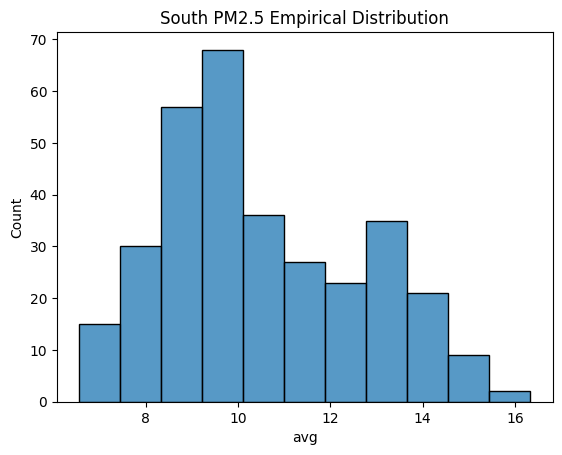

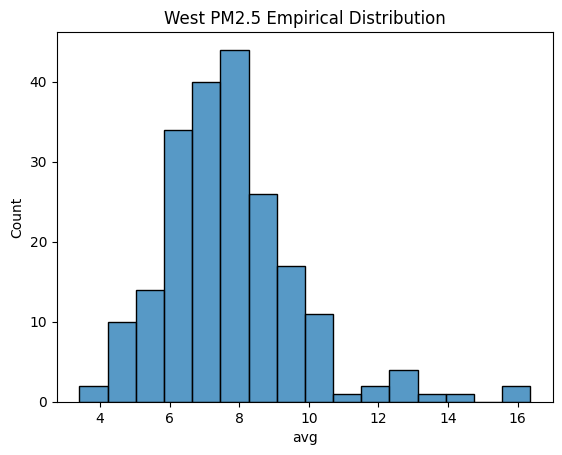

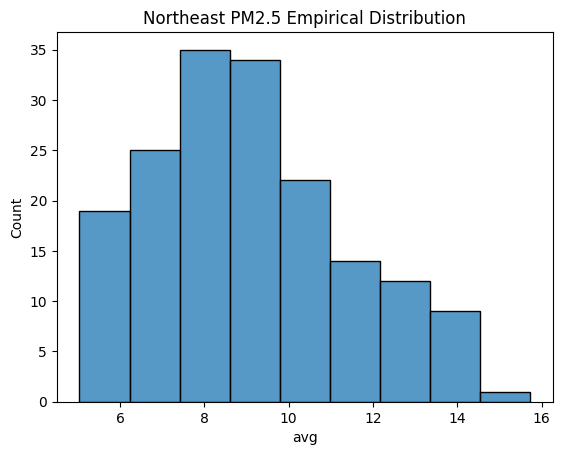

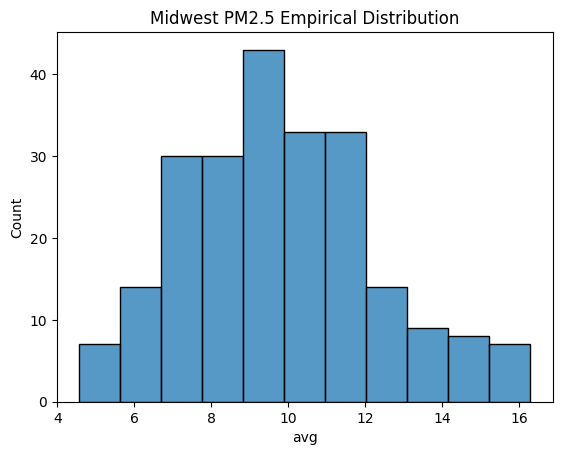

In [ ]:
for region in pm.region.unique():
    sns.histplot(pm[pm.region == region], x = 'avg')
    plt.title(f'{region} PM2.5 Empirical Distribution')
    plt.show()

In [ ]:
data

,year,state,region,avg_pm,avg_asthma,population,temporal_period
0,2010,Alabama,South,10.932483,0.001190,4785514.0,0
1,2010,Florida,South,7.645126,0.310170,18846143.0,0
2,2010,Georgia,South,11.667607,0.001080,9712209.0,0
3,2010,Idaho,West,7.246638,0.001350,1570819.0,0
4,2010,Illinois,Midwest,11.927143,0.001390,12840545.0,0
...,...,...,...,...,...,...,...
469,2019,Wisconsin,Midwest,7.239871,37.828734,5824581.0,2
470,2016,Wyoming,West,4.150661,39.783333,585243.0,1
471,2017,Wyoming,West,5.298474,43.316667,579994.0,1
472,2018,Wyoming,West,4.888572,36.950000,579054.0,2


In [ ]:
def categorize_year(year):
    if year <= 2013:
        return 0
    elif year <= 2017:
        return 1
    else:
        return 2

# Apply this function to the 'Year' column to create 'temporal_period'



asthma_grouped = asth_fil.groupby(['Year', 'LocationDesc', 'Region'])[['DataValue', 'Population']].mean().reset_index()
data = pd.merge(pm, asthma_grouped, left_on=['year', 'state', 'region'], right_on=['Year', 'LocationDesc', 'Region'])[['year', 'state', 'region', 'avg', 'DataValue', 'Population']].rename(columns={'DataValue': 'avg_asthma', 'avg': 'avg_pm', 'Population': 'population'})
# data = pd.merge(data, lifestyle_, on=['year', 'state', 'region'])
# data.head()
# print(data.isna().sum())
# data = data.drop(columns=['Immunization', 'Mental Health', 'Oral Health', 'Tobacco'])
data['temporal_period'] = data['year'].apply(categorize_year)
data

,year,state,region,avg_pm,avg_asthma,population,temporal_period
0,2010,Alabama,South,10.932483,0.001190,4785514.0,0
1,2010,Florida,South,7.645126,0.310170,18846143.0,0
2,2010,Georgia,South,11.667607,0.001080,9712209.0,0
3,2010,Idaho,West,7.246638,0.001350,1570819.0,0
4,2010,Illinois,Midwest,11.927143,0.001390,12840545.0,0
...,...,...,...,...,...,...,...
469,2019,Wisconsin,Midwest,7.239871,37.828734,5824581.0,2
470,2016,Wyoming,West,4.150661,39.783333,585243.0,1
471,2017,Wyoming,West,5.298474,43.316667,579994.0,1
472,2018,Wyoming,West,4.888572,36.950000,579054.0,2


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import poisson
import numpy as np

lambda_param = 3
X = np.arange(39437610)

poisson_vals = poisson.pmf(X, lambda_param)

plt.plot(X, poisson_vals, label="Poisson Distribution Estimation")
plt.hist(population)
plt.title("State Populations Distribution")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
new_data = data.groupby(['state', 'region','temporal_period']).mean().reset_index().drop(['year'], axis = 1)

In [ ]:
data_10_13 = new_data[new_data['temporal_period'] == 0].rename(columns={'avg_pm': '2010-13 avg_pm', 'avg_asthma': '2010-13 avg_asthma', 'population': '2010-13 population'}).drop(columns=['temporal_period'])
data_14_17 = new_data[new_data['temporal_period'] == 1].rename(columns={'avg_pm': '2014-17 avg_pm', 'avg_asthma': '2014-17 avg_asthma', 'population': '2014-17 population'}).drop(columns=['temporal_period'])
data_18_21 = new_data[new_data['temporal_period'] == 2].rename(columns={'avg_pm': '2018-21 avg_pm', 'avg_asthma': '2018-21 avg_asthma', 'population': '2018-21 population'}).drop(columns=['temporal_period'])
print(len(data_18_21), len(data_14_17), len(data_10_13))

merge_1 = data_10_13.merge(data_14_17, how='left', on=['state', 'region'])
asth_final = merge_1.merge(data_18_21, how='left', on=['state', 'region'])
asth_final['avg_pm'] = (asth_final['2010-13 avg_pm'] + asth_final['2014-17 avg_pm'] + asth_final['2018-21 avg_pm']) / 3
asth_final['avg_asthma'] = (asth_final['2010-13 avg_asthma'] + asth_final['2014-17 avg_asthma'] + asth_final['2018-21 avg_asthma']) / 3
asth_final['total population'] = (asth_final['2010-13 population'] + asth_final['2014-17 population'] + asth_final['2018-21 population']) / 3
asth_final['total asthma'] = (asth_final['avg_asthma'] / 100) * asth_final['total population']
display(asth_final)

asthm_regions = asth_final.drop(columns=['state']).groupby('region').mean()
asthm_regions

48 48 48


,state,region,2010-13 avg_pm,2010-13 avg_asthma,2010-13 population,2014-17 avg_pm,2014-17 avg_asthma,2014-17 population,2018-21 avg_pm,2018-21 avg_asthma,2018-21 population,avg_pm,avg_asthma,total population,total asthma
0,Alabama,South,10.516307,26.793250,4.808344e+06,9.899100,36.539440,4860838.25,8.827862,34.078729,4899796.5,9.747756,32.470473,4.856326e+06,1.576872e+06
1,Arizona,West,7.442713,23.516667,6.517948e+06,6.695533,27.681149,6889634.50,5.343119,30.204257,7228035.5,6.493788,27.134024,6.878539e+06,1.866425e+06
2,Arkansas,South,10.320137,24.881011,2.944093e+06,9.221292,29.681087,2986040.25,8.861412,30.001317,3016573.0,9.467613,28.187805,2.982235e+06,8.406267e+05
3,California,West,10.168786,26.153064,3.778854e+07,9.416601,35.925136,38994493.25,8.888835,35.292983,39437536.5,9.491407,32.457061,3.874019e+07,1.257393e+07
4,Colorado,West,6.663421,27.128551,5.158468e+06,5.963597,33.307426,5492057.50,5.145177,34.113921,5727820.5,5.924065,31.516633,5.459449e+06,1.720634e+06
5,Connecticut,Northeast,8.503209,26.914631,3.589702e+06,7.384949,37.103714,3584853.00,6.946891,35.435857,3570291.5,7.611683,33.151401,3.581616e+06,1.187356e+06
6,Delaware,South,9.376554,44.661111,9.157233e+05,8.719425,46.175000,945781.75,7.485029,40.875693,971826.5,8.527003,43.903935,9.444439e+05,4.146480e+05
7,Florida,South,7.170176,22.062709,1.918886e+07,7.545801,26.207946,20419329.25,7.522206,29.958137,21373491.0,7.412727,26.076264,2.032723e+07,5.300581e+06
8,Georgia,South,10.655409,25.561092,9.848753e+06,9.725977,30.820789,10245007.50,8.779550,29.693003,10573704.5,9.720312,28.691628,1.022249e+07,2.932998e+06
9,Idaho,West,7.505412,27.348646,1.590764e+06,7.862781,32.857320,1672131.00,6.171055,38.341667,1770567.0,7.179749,32.849211,1.677820e+06,5.511508e+05


,2010-13 avg_pm,2010-13 avg_asthma,2010-13 population,2014-17 avg_pm,2014-17 avg_asthma,2014-17 population,2018-21 avg_pm,2018-21 avg_asthma,2018-21 population,avg_pm,avg_asthma,total population,total asthma
region,,,,,,,,,,,,,
Midwest,9.671680,28.035636,5.606106e+06,8.061237,34.278669,5.663120e+06,7.209986,35.847367,5.691796e+06,8.314301,32.720558,5.653674e+06,1.796138e+06
Northeast,8.506889,31.319627,6.185904e+06,7.250572,36.660004,6.228369e+06,6.507043,35.478101,6.227082e+06,7.421501,34.485911,6.213785e+06,1.939733e+06
South,9.694238,27.134195,7.250836e+06,8.841662,33.833722,7.562825e+06,8.055530,34.007178,7.778853e+06,8.863810,31.658365,7.530838e+06,2.290067e+06
West,7.404630,28.169809,6.457328e+06,6.788065,33.795190,6.724319e+06,5.939641,35.749741,6.901496e+06,6.710779,32.571580,6.694381e+06,2.119690e+06


In [ ]:
proportions = asth_final['avg_asthma']/100 #filter out the high population counties
m = np.mean(proportions)
V = np.var(proportions)
a = ((m*m*(1-m))/V) - m
b = (((1-m)*(1-m)*m)/V) - (1-m)
aes = a
bes = b
display(a, b)
asth_final['bayesestimate'] = ((asth_final['avg_asthma']/100 * asth_final['total population']) + a)/(asth_final['total population'] + a + b)

31.75176030265399

65.45735689284868

In [ ]:
!pip install graphviz==0.20.1

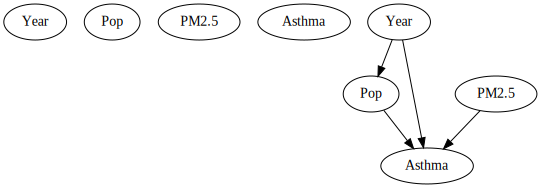

In [ ]:
from graphviz import Digraph

dot = Digraph()

dot.node('year', 'Year')
dot.node('pop', 'Pop')
dot.node('pm2.5', 'PM2.5')
dot.node('asthma', 'Asthma')

dot.edge('Year', 'Pop')
dot.edge('Year', 'Asthma')
dot.edge('PM2.5', 'Asthma')
dot.edge('Pop', 'Asthma')

dot

In [ ]:
dfg = asth_final.copy()

In [ ]:
dfg['naiveproportion'] = (dfg['2010-13 avg_asthma'] + dfg['2014-17 avg_asthma'] + dfg['2018-21 avg_asthma']) /3
proportions_largestates = dfg['naiveproportion'][dfg['2018-21 population'] >= 20000000]

m = np.mean(proportions_largestates)
V = np.var(proportions_largestates)
a = ((m*m*(1-m))/V) - m
b = (((1-m)*(1-m)*m)/V) - (1-m)
aes = a
bes = b

# Priors for each state
dfg['bayesestimate'] = ((dfg['2018-21 avg_asthma']*dfg['2018-21 population']) + a)/(dfg['2018-21 population'] + a + b)

In [ ]:
dfg['population'] = dfg['total population']
dfg['pm2.5'] = (dfg['2010-13 avg_pm'] + dfg['2014-17 avg_pm'] +  dfg['2018-21 avg_pm'])/3
dfg['asthma'] = (dfg['2010-13 avg_asthma'] + dfg['2014-17 avg_asthma'] +  dfg['2018-21 avg_asthma'])/3
df2 = dfg[['state', 'region', 'asthma', 'population', 'pm2.5', 'bayesestimate']]

In [ ]:
west_model = df2[df2.region == 'West']
south_model = df2[df2.region == 'South']
ne_model = df2[df2.region == 'Northeast']
mw_data = df2[df2.region == 'Midwest']
west_model

,state,region,asthma,population,pm2.5,bayesestimate
1,Arizona,West,27.134024,6.878539e+06,6.493788,30.204259
3,California,West,32.457061,3.874019e+07,9.491407,35.292997
4,Colorado,West,31.516633,5.459449e+06,5.924065,34.113997
9,Idaho,West,32.849211,1.677820e+06,7.179749,38.342175
23,Montana,West,42.324074,1.036263e+06,5.970436,42.984653
25,Nevada,West,26.438654,2.896611e+06,6.351720,30.774448
28,New Mexico,West,31.627288,2.089863e+06,5.732420,35.422438
34,Oregon,West,30.683081,4.046530e+06,7.540747,34.107147
41,Utah,West,32.084425,3.010828e+06,6.918403,37.307536
44,Washington,West,31.897930,7.222475e+06,7.380727,36.508500


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm, expon, gamma, poisson, uniform

def find_dist(region, df):
    cols = df.columns
    
    for col in cols:
        if col not in ['state', 'region']:
            column_data = df[col].values
            plt.hist(df[col].values, density=True)
            params_norm = norm.fit(column_data)
            params_expon = expon.fit(column_data)
            params_gamma = gamma.fit(column_data)
            params_beta = beta.fit(column_data)
            params_uniform = uniform.fit(column_data)

            x = np.linspace(min(column_data), max(column_data), 100)

            
            #pdf_poisson = poisson.pmf(x, *params_poisson)
            pdf_uniform = uniform.pdf(x, *params_uniform)
            pdf_norm = norm.pdf(x, *params_norm)
            pdf_expon = expon.pdf(x, *params_expon)
            pdf_gamma = gamma.pdf(x, *params_gamma)
            pdf_beta = beta.pdf(x, *params_beta)

            plt.plot(x, pdf_norm, label='Normal')
            plt.plot(x, pdf_expon, label='Exponential')
            plt.plot(x, pdf_gamma, label='Gamma')
            plt.plot(x, pdf_beta, label='Beta')
            plt.plot(x, pdf_uniform, label="Uniform")
            plt.title(f'Fitted Distributions for {region} {col} Model')
            plt.legend()
            plt.show()

            print("Normal Params:" , params_norm)
            print("Exponential Params: ", params_expon)
            print("Gamma Params: " , params_gamma)
            #print(params_poisson)
            print("Uniform Params: ", params_uniform)
            print("Beta Params: ", params_beta)
        else: 
            continue


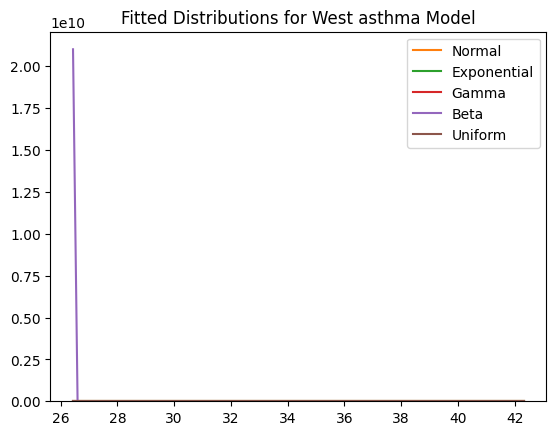

Normal Params: (32.571580109577916, 4.406391234638452)
Exponential Params:  (26.43865396329365, 6.132926146284266)
Gamma Params:  (2.8082023230578397, 24.878023088587582, 2.739667561343225)
Uniform Params:  (26.43865396329365, 15.885420110780426)
Beta Params:  (0.2169997414516719, 0.9201766192306782, 26.438653963293646, 28.738729721078307)


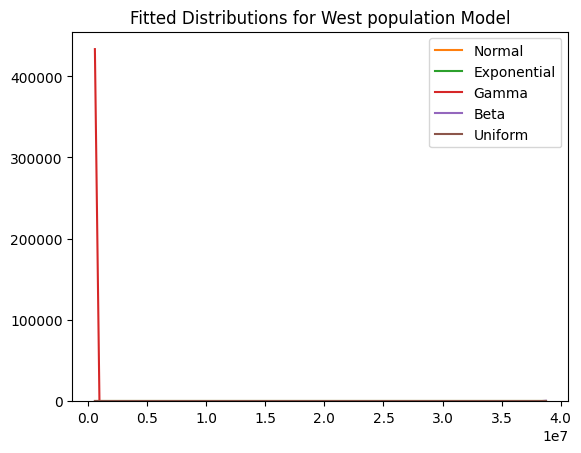

Normal Params: (6694381.237373739, 10355264.767755585)
Exponential Params:  (579623.4166666666, 6114757.820707072)
Gamma Params:  (0.21667161909915167, 579623.4166666665, 10318507.39430188)
Uniform Params:  (579623.4166666666, 38160568.16666667)
Beta Params:  (0.03318942940684946, 0.24641592068719878, -3122846.9003388425, 41863038.48367219)


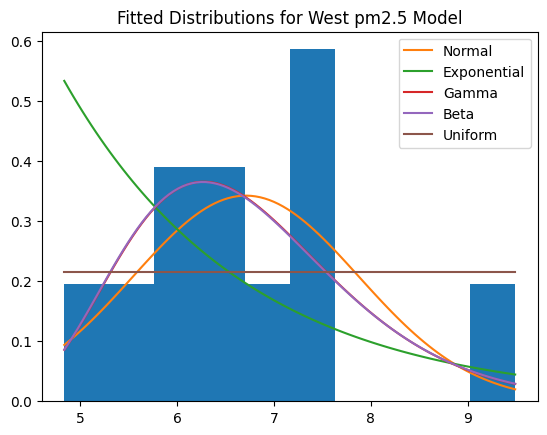

Normal Params: (6.7107786900327575, 1.1658395134484565)
Exponential Params:  (4.835101880405206, 1.8756768096275511)
Gamma Params:  (7.093866826855012, 3.615660689103023, 0.43630889569193587)
Uniform Params:  (4.835101880405206, 4.6563053680985735)
Beta Params:  (6.857528471580977, 11660.478110207961, 3.6569578997334062, 5197.292416559904)


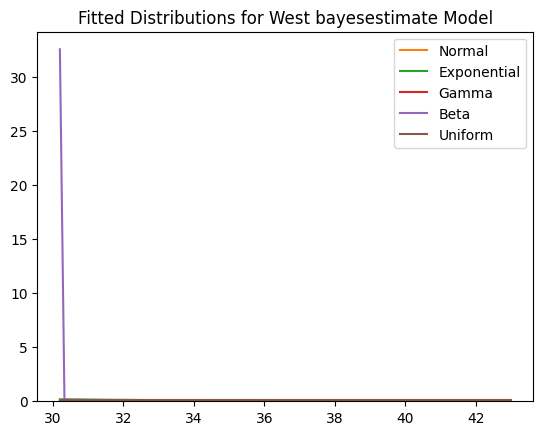

Normal Params: (35.75012216288565, 3.4276017201168383)
Exponential Params:  (30.20425898164454, 5.545863181241113)
Gamma Params:  (38.474142902385566, 14.4433676301231, 0.5537941235303159)
Uniform Params:  (30.20425898164454, 12.780393970222466)
Beta Params:  (0.8317835575929391, 1.3480199217840392, 30.204258981644536, 13.942022338113151)


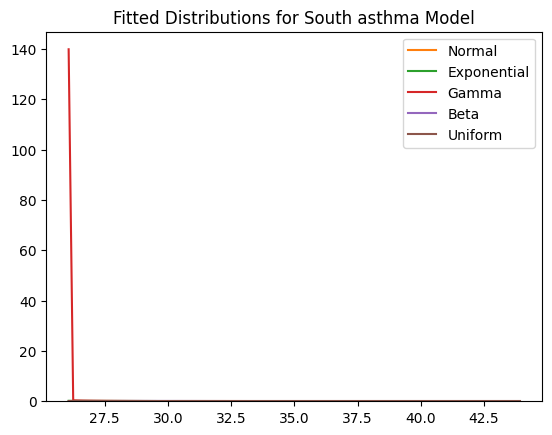

Normal Params: (31.65836474268353, 3.9640318189948895)
Exponential Params:  (26.0762641005291, 5.58210064215443)
Gamma Params:  (0.809547058028318, 26.076264100529094, 3.99383421942432)
Uniform Params:  (26.0762641005291, 17.82767055555555)
Beta Params:  (3.2079628979799137, 22597153549.38851, 24.916305255511837, 47465252573.6773)


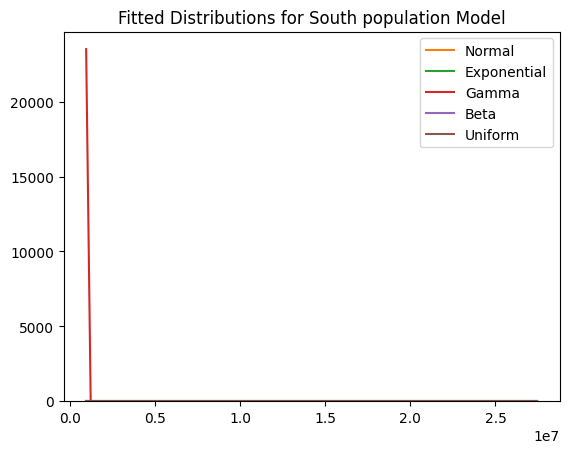

Normal Params: (7530838.038194444, 6802655.905745728)
Exponential Params:  (944443.8611111111, 6586394.177083333)
Gamma Params:  (0.29843765120884747, 944443.861111111, 12658087.05349207)
Uniform Params:  (944443.8611111111, 26498105.638888888)
Beta Params:  (0.5108436526516835, 0.7405232834702156, 944443.861111111, 26498105.63888889)


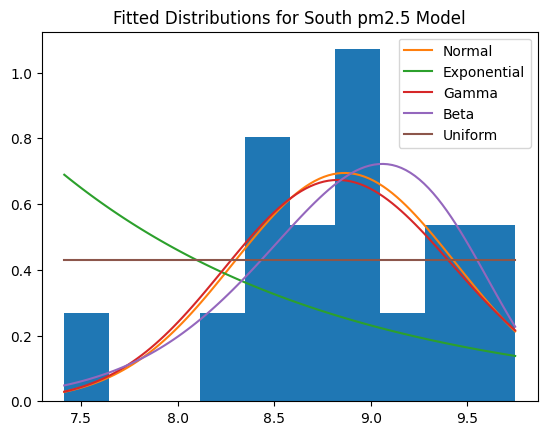

Normal Params: (8.863809972707731, 0.5744733990008077)
Exponential Params:  (7.412727484875437, 1.451082487832294)
Gamma Params:  (324.74827746552126, -1.8313044441506827, 0.03292766521150384)
Uniform Params:  (7.412727484875437, 2.3350287045372484)
Beta Params:  (2551398.747467086, 8.814725848225134, -498973.399835395, 498983.9875815932)


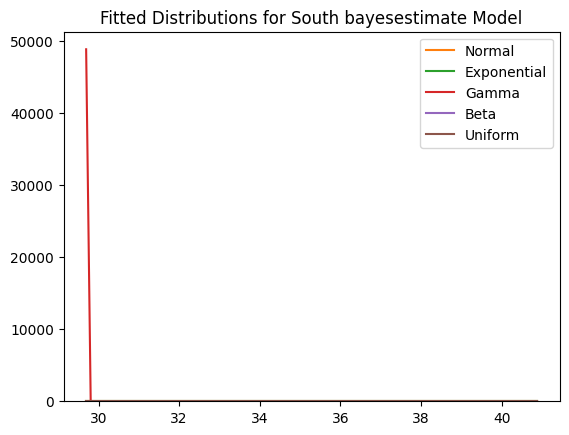

Normal Params: (34.00733786685551, 3.1052550014757294)
Exponential Params:  (29.692999137048375, 4.314338729807133)
Gamma Params:  (0.6356857781904336, 29.69299913704837, 4.667656763021753)
Uniform Params:  (29.692999137048375, 11.18390481231095)
Beta Params:  (0.9534428638243833, 2.981744157470649, 29.69299913704837, 16.440050506315536)


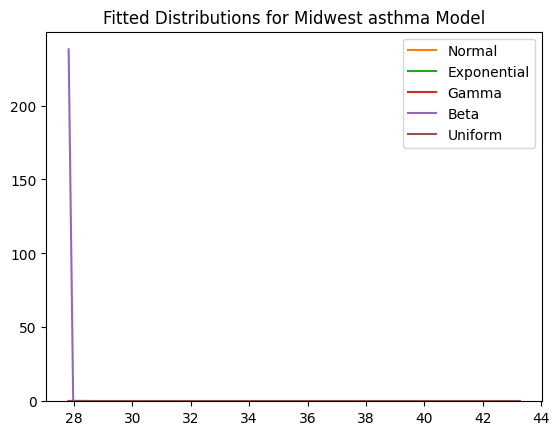

Normal Params: (32.720557545056224, 3.919121587716326)
Exponential Params:  (27.812877698412702, 4.907679846643521)
Gamma Params:  (1.671073936948675, 27.46652685374024, 3.144108933072869)
Uniform Params:  (27.812877698412702, 15.452863042328037)
Beta Params:  (0.7820151473198846, 3.1301785240828854, 27.8128776984127, 23.728206154386832)


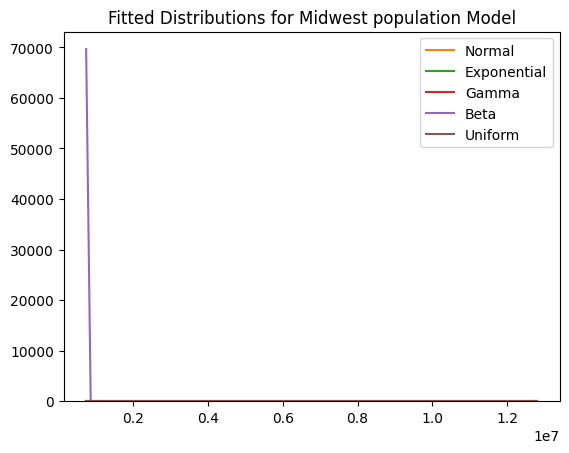

Normal Params: (5653674.277777777, 3890471.505381321)
Exponential Params:  (739104.1666666666, 4914570.11111111)
Gamma Params:  (0.6087054650041215, 739104.1666666665, 7675551.279326849)
Uniform Params:  (739104.1666666666, 12062297.333333334)
Beta Params:  (0.26322341655915105, 0.8197338251395132, 739104.1666666665, 12062297.333335897)


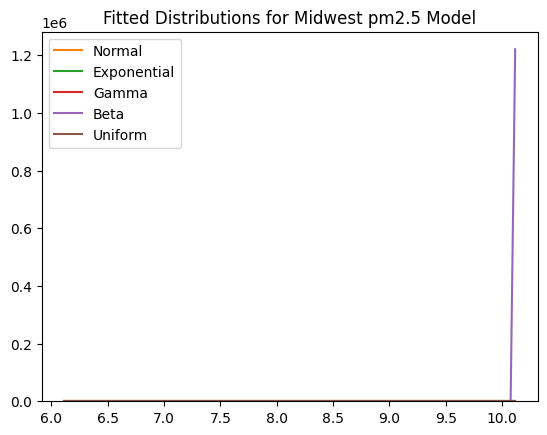

Normal Params: (8.314301098881295, 1.3159890817025517)
Exponential Params:  (6.115265571596386, 2.1990355272849085)
Gamma Params:  (471.44779033860937, -20.453496019986744, 0.06102110992153564)
Uniform Params:  (6.115265571596386, 4.00019372486955)
Beta Params:  (1.720594253288832, 0.5584172412539669, 4.80909584134542, 5.3063634551205165)


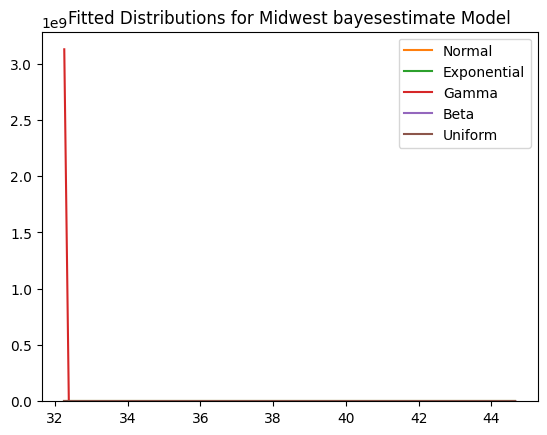

Normal Params: (35.84771999950771, 3.3703560838925872)
Exponential Params:  (32.26049749426635, 3.587222505241357)
Gamma Params:  (0.27764949206769723, 32.260497494266346, 5.879373817157524)
Uniform Params:  (32.26049749426635, 12.39158730175123)
Beta Params:  (0.5566457242746834, 2.430472297430229, 32.260497494266346, 15.646643907729205)


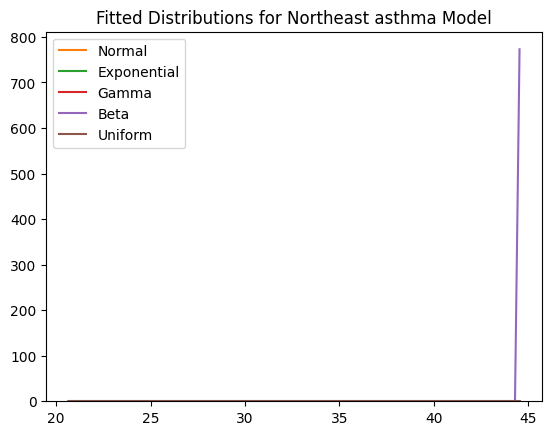

Normal Params: (34.48591051366843, 6.493465326230403)
Exponential Params:  (20.659983227513226, 13.825927286155203)
Gamma Params:  (268.4366048019367, -74.52319513426811, 0.4060042043351625)
Uniform Params:  (20.659983227513226, 23.89510936507936)
Beta Params:  (1.9634688262997382, 0.7163635402963221, 9.060452602476293, 35.49463999011631)


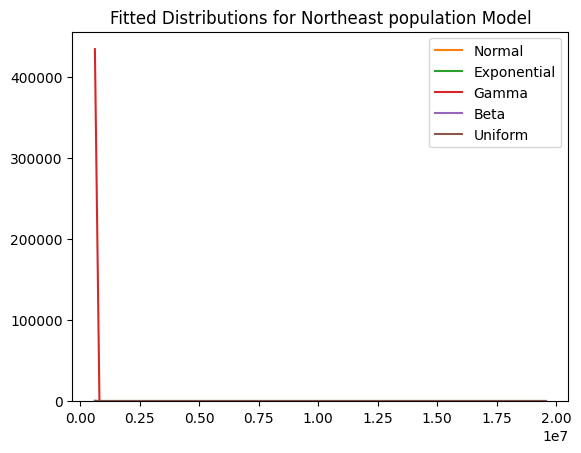

Normal Params: (6213785.222222223, 6153478.2658474175)
Exponential Params:  (625395.3333333334, 5588389.88888889)
Gamma Params:  (0.22204547333901514, 625395.3333333333, 4478874.395942939)
Uniform Params:  (625395.3333333334, 18929286.083333336)
Beta Params:  (0.4003950945435095, 1.0298620337615043, 625395.3333333333, 19413345.413487673)


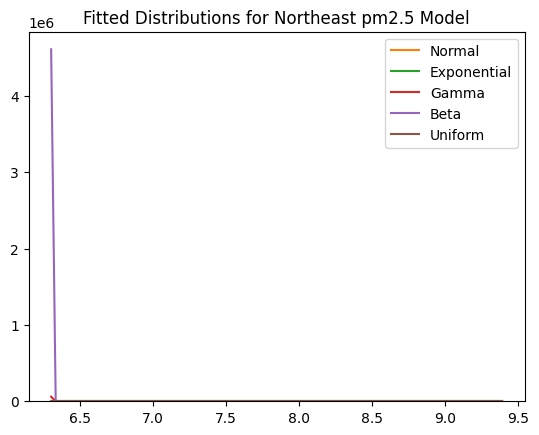

Normal Params: (7.421501442093326, 1.0492525308733165)
Exponential Params:  (6.303899726649166, 1.1176017154441595)
Gamma Params:  (0.6751401893028737, 6.303899726649165, 0.9585050771488139)
Uniform Params:  (6.303899726649166, 3.0862118774640086)
Beta Params:  (0.5205217541654226, 0.9766270335387849, 6.303899726649165, 3.200696612483359)


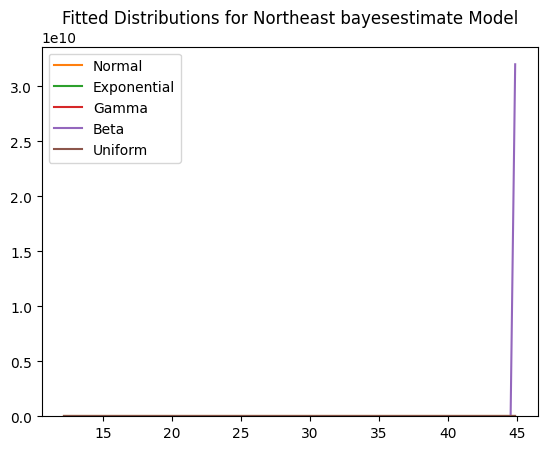

Normal Params: (35.478622871352144, 8.763130424253232)
Exponential Params:  (12.178117285295887, 23.300505586056257)
Gamma Params:  (207.15978333474015, -99.24113766904486, 0.6503540060852058)
Uniform Params:  (12.178117285295887, 32.71473842534553)
Beta Params:  (0.9125399359076907, 0.18111496666326812, 8.552815224909738, 36.340040485731684)


In [ ]:
tmp = {'West': west_model, 
    'South': south_model, 
    'Midwest': mw_model, 
    'Northeast': ne_model}

for k,v in tmp.items():
    find_dist(k, v)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [population, asthma, PM2.5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'Bayesian Analysis of West Asthma Data')

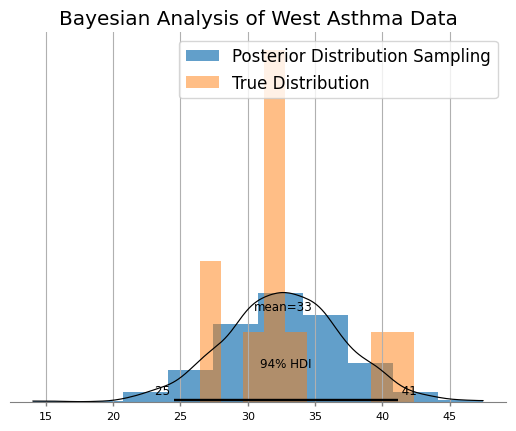

In [ ]:
import arviz as az

w_model = pymc.Model()

with w_model:
    population = pymc.Gamma('population', 0.21667161909915167, 579623.4166666665, 10318507.39430188)
    asthma = pymc.Normal('asthma', 32.571580109577916, 4.406391234638452)
    pm25 = pymc.Beta('PM2.5', 6.857528471580977, 11660.478110207961)
    idata = pymc.sample(1000, chains=2, return_inferencedata=True)

az.plot_posterior(idata, var_names='asthma', textsize = 8, color='black')
plt.hist(idata.posterior['asthma'].values.flatten(), density=True, alpha=0.7, label='Posterior Distribution Sampling')
plt.hist(west_model.asthma, density=True, label='True Distribution', alpha=0.5)
plt.legend()
plt.grid()
plt.title("Bayesian Analysis of West Asthma Data")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [population, asthma, PM2.5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'Bayesian Analysis of South Asthma Data')

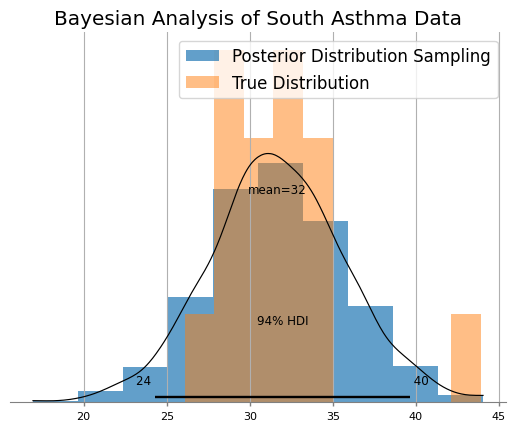

In [ ]:
s_model = pymc.Model()

with s_model:
    population = pymc.Normal('population', 7530838.038194444, 6802655.905745728)
    asthma = pymc.Normal('asthma',31.65836474268353, 3.9640318189948895)
    pm25 = pymc.Normal('PM2.5', 8.863809972707731, 0.5744733990008077)
    idata = pymc.sample(1000, chains=2, return_inferencedata=True)

az.plot_posterior(idata, var_names='asthma', textsize = 8, color='black')
plt.hist(idata.posterior['asthma'].values.flatten(), density=True, alpha=0.7, label='Posterior Distribution Sampling')
plt.hist(south_model.asthma, density=True, label='True Distribution', alpha=0.5)
plt.legend()
plt.grid()
plt.title("Bayesian Analysis of South Asthma Data")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [population, asthma, PM2.5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'Bayesian Analysis of Midwest Asthma Data')

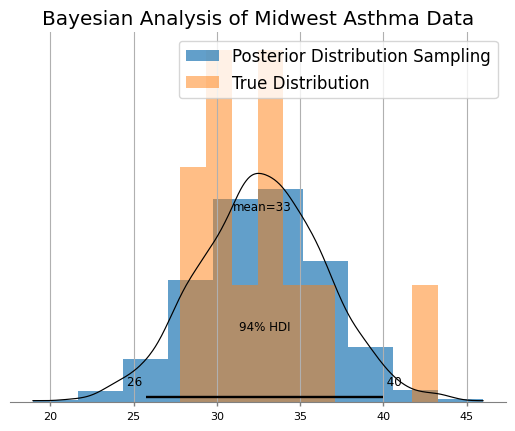

In [ ]:
mw_model = pymc.Model()

with mw_model:
    population = pymc.Normal('population', 5653674.277777777, 3890471.505381321)
    asthma = pymc.Normal('asthma',32.720557545056224, 3.919121587716326)
    pm25 = pymc.Normal('PM2.5', 8.314301098881295, 1.3159890817025517)
    idata = pymc.sample(1000, chains=2, return_inferencedata=True)

az.plot_posterior(idata, var_names='asthma', textsize = 8, color='black')
plt.hist(idata.posterior['asthma'].values.flatten(), density=True, alpha=0.7, label='Posterior Distribution Sampling')
plt.hist(mw_data.asthma, density=True, label='True Distribution', alpha=0.5)
plt.legend()
plt.grid()
plt.title("Bayesian Analysis of Midwest Asthma Data")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [population, asthma, PM2.5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'Bayesian Analysis of Northeast Asthma Data')

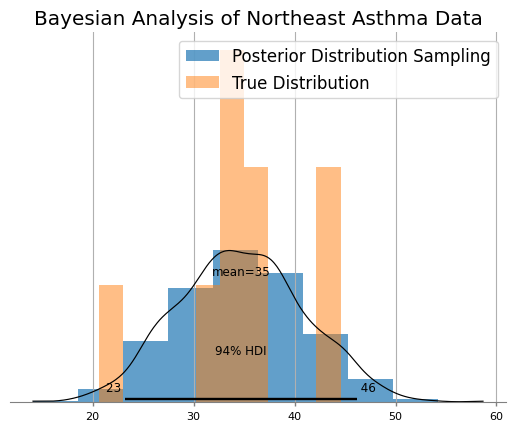

In [ ]:
ne = pymc.Model()

with ne:
    population = pymc.Gamma('population', 0.22204547333901514, 625395.3333333333, 4478874.395942939)
    asthma = pymc.Normal('asthma', 34.48591051366843, 6.493465326230403)
    pm25 = pymc.Normal('PM2.5', 7.421501442093326, 1.0492525308733165)
    idata = pymc.sample(1000, chains=2, return_inferencedata=True)

az.plot_posterior(idata, var_names='asthma', textsize = 8, color='black')
plt.hist(idata.posterior['asthma'].values.flatten(), density=True, alpha=0.7, label='Posterior Distribution Sampling')
plt.hist(ne_model.asthma, density=True, label='True Distribution', alpha=0.5)
plt.legend()
plt.grid()
plt.title("Bayesian Analysis of Northeast Asthma Data")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e9786156-6c75-4038-b6c5-bd0fb91e0e78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>